# Dual-Path Kidney Classification Training Pipeline

This notebook implements the complete training pipeline for the dual-path kidney condition classification model with evidential uncertainty quantification.

## Features
- **Dual-Path Architecture**: EfficientNet-B4 + Lightweight CNN
- **Cross-Attention Fusion**: Dynamic feature integration
- **Evidential Learning**: Dirichlet-based uncertainty quantification
- **Clinical Optimization**: Priority-aware training with Youden index
- **Advanced Monitoring**: Comprehensive metrics and visualization

## Model Components
1. **Path A**: EfficientNet-B4 backbone (global features)
2. **Path B**: Lightweight CNN (local features)
3. **Fusion**: Cross-attention mechanism
4. **Output**: Classification + Uncertainty estimation

## Clinical Classes
- **Tumor**: High recall priority (catch all cases)
- **Stone**: Balanced precision-recall
- **Cyst**: Balanced precision-recall  
- **Normal**: High precision priority (avoid false alarms)

In [3]:
import sys
from pathlib import Path

sys.path.append("/kaggle/input/finalwithdrichletandotherscripts")

In [4]:
# Import Required Libraries
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
from datetime import datetime
import json
import pickle

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")

Libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4


In [5]:
# Import Project Modules
from config import *
from models import create_model, DualPathKidneyClassifier
from training_pipeline import KidneyTrainer
from loss import create_loss_function
from utils import compute_metrics, thresholded_predictions
from evidential import compute_evidential_metrics
from dataloader import create_datasets, create_dataloaders

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("Project modules imported successfully!")

Using device: cuda
Project modules imported successfully!


In [6]:
# Display Configuration
print("=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)

print(f"\nModel Configuration:")
for key, value in MODEL_CONFIG.items():
    print(f"  {key}: {value}")

print(f"\nTraining Configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

print(f"\nClass Information:")
print(f"  Classes: {CLASS_NAMES}")
print(f"  Number of classes: {NUM_CLASSES}")

print(f"\nClass Weights:")
for class_name, weight in CLASS_WEIGHTS.items():
    print(f"  {class_name}: {weight:.3f}")

print(f"\nClass Thresholds:")
for class_name, threshold in CLASS_THRESHOLDS.items():
    print(f"  {class_name}: {threshold:.3f}")

print(f"\nData Configuration:")
for key, value in DATA_CONFIG.items():
    if key != 'augmentation':
        print(f"  {key}: {value}")

print(f"\nData Augmentation:")
for key, value in DATA_CONFIG['augmentation'].items():
    print(f"  {key}: {value}")

TRAINING CONFIGURATION

Model Configuration:
  efficientnet_model: efficientnet_b4
  input_size: 380
  feature_dim: 512
  attention_dim: 256
  dropout_rate: 0.3
  confidence_loss_weight: 0.1
  scheduler_step_size: 10
  scheduler_gamma: 0.5

Training Configuration:
  batch_size: 16
  learning_rate: 8e-05
  num_epochs: 50
  patience: 12
  min_delta: 0.001
  warmup_epochs: 5
  weight_decay: 0.0002
  gradient_clip_norm: 1.0

Class Information:
  Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
  Number of classes: 4

Class Weights:
  Cyst: 0.840
  Normal: 0.610
  Stone: 2.260
  Tumor: 1.360

Class Thresholds:
  Cyst: 0.500
  Normal: 0.600
  Stone: 0.500
  Tumor: 0.350

Data Configuration:
  train_split: 0.7
  val_split: 0.15
  test_split: 0.15

Data Augmentation:
  rotation_degrees: 15
  brightness: 0.1
  contrast: 0.1
  saturation: 0.1
  hue: 0.05


In [7]:
# Dataset Loading and Analysis
DATA_DIR = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"  # Update this path to your dataset

print("=" * 60)
print("DATASET LOADING")
print("=" * 60)

if os.path.exists(DATA_DIR):
    print(f"Loading datasets from: {DATA_DIR}")
    
    # Create datasets
    datasets = create_datasets(DATA_DIR)
    
    # Display dataset information
    total_samples = 0
    for split_name, dataset in datasets.items():
        split_size = len(dataset)
        total_samples += split_size
        print(f"\n{split_name.upper()} Dataset:")
        print(f"  Size: {split_size:,}")
        
        # Get class distribution
        distribution = dataset.get_class_distribution()
        for class_name, count in distribution.items():
            percentage = (count / split_size) * 100
            print(f"  {class_name}: {count:,} ({percentage:.1f}%)")
    
    print(f"\nTotal dataset size: {total_samples:,}")
    
    # Create dataloaders
    dataloaders = create_dataloaders(datasets, batch_size=TRAINING_CONFIG['batch_size'])
    print(f"\nDataloaders created with batch size: {TRAINING_CONFIG['batch_size']}")
    
    # Display batch information
    for split_name, dataloader in dataloaders.items():
        print(f"  {split_name}: {len(dataloader)} batches")
        
else:
    print(f"Dataset directory not found: {DATA_DIR}")
    print("Please update DATA_DIR to point to your dataset location")
    datasets = None
    dataloaders = None

DATASET LOADING
Loading datasets from: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone
Found class directories: ['Cyst', 'Normal', 'Stone', 'Tumor']
  Cyst: 3709 images
  Normal: 5077 images
  Stone: 1377 images
  Tumor: 2283 images

Total loaded: 12446 images from 4 classes

Data splits:
  train: 8712 samples
    Cyst: 2597
    Normal: 3553
    Stone: 964
    Tumor: 1598
  val: 1867 samples
    Cyst: 556
    Normal: 762
    Stone: 206
    Tumor: 343
  test: 1867 samples
    Cyst: 556
    Normal: 762
    Stone: 207
    Tumor: 342

TRAIN Dataset:
  Size: 8,712
  Cyst: 2,597 (29.8%)
  Normal: 3,553 (40.8%)
  Stone: 964 (11.1%)
  Tumor: 1,598 (18.3%)

VAL Dataset:
  Size: 1,867
  Cyst: 556 (29.8%)
  Normal: 762 (40.8%)
  Stone: 206 (11.0%)
  Tumor: 343 (18.4%)

TEST Dataset:
  Size: 1,867
  Cyst: 556 (29.8%)
  Normal: 762 (40.8%)
  Stone: 207 (11.1%)
  Tumor: 342 (18.3%)

Total dataset size: 12

In [8]:
# Model Creation and Architecture Display
print("=" * 60)
print("MODEL ARCHITECTURE")
print("=" * 60)

if datasets is not None:
    # Create the dual-path model
    model = create_model('full')  # Full dual-path with cross-attention
    model = model.to(device)
    
    print("Dual-Path Model Created Successfully!")
    
    # Display model architecture
    print(f"\nModel Architecture: {type(model).__name__}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")
    
    # Test forward pass
    print(f"\nTesting forward pass...")
    dummy_input = torch.randn(2, 3, MODEL_CONFIG['input_size'], MODEL_CONFIG['input_size']).to(device)
    
    with torch.no_grad():
        # Test evidential mode
        evidential_output, confidence = model(dummy_input, use_evidential=True)
        print(f"Evidential forward pass successful!")
        print(f"  Input shape: {dummy_input.shape}")
        print(f"  Probabilities shape: {evidential_output['prob'].shape}")
        print(f"  Confidence shape: {confidence.shape}")
        print(f"  Uncertainty shape: {evidential_output['uncertainty'].shape}")
        
        # Test standard mode
        logits, confidence_std = model(dummy_input, use_evidential=False)
        print(f"Standard forward pass successful!")
        print(f"  Logits shape: {logits.shape}")
        print(f"  Confidence shape: {confidence_std.shape}")
        
else:
    print("Cannot create model - datasets not loaded")
    model = None

MODEL ARCHITECTURE


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Dual-Path Model Created Successfully!

Model Architecture: DualPathKidneyClassifier
Total parameters: 19,713,361
Trainable parameters: 19,713,361
Non-trainable parameters: 0

Testing forward pass...
Evidential forward pass successful!
  Input shape: torch.Size([2, 3, 380, 380])
  Probabilities shape: torch.Size([2, 4])
  Confidence shape: torch.Size([2, 1])
  Uncertainty shape: torch.Size([2, 1])
Standard forward pass successful!
  Logits shape: torch.Size([2, 4])
  Confidence shape: torch.Size([2, 1])


In [9]:
!mkdir checkpoints
!mkdir checkpoints/dual_path_evidential

In [11]:
# Training Setup
print("=" * 60)
print("TRAINING SETUP")
print("=" * 60)

if model is not None and dataloaders is not None:
    # Create trainer with evidential learning
    trainer = KidneyTrainer(
        model=model,
        train_loader=dataloaders['train'],
        val_loader=dataloaders['val'],
        device=device,
        loss_type='evidential',  # Use evidential learning for uncertainty quantification
        use_freezing=FREEZING_CONFIG['enabled'],
        save_dir='checkpoints/dual_path_evidential'
    )
    
    print("Trainer created successfully!")
    print(f"Training batches: {len(trainer.train_loader)}")
    print(f"Validation batches: {len(trainer.val_loader)}")
    print(f"Loss type: evidential (Dirichlet uncertainty)")
    print(f"Freezing enabled: {FREEZING_CONFIG['enabled']}")
    
    # Display optimizer information
    print(f"\nOptimizer: {type(trainer.optimizer).__name__}")
    print(f"Scheduler: {type(trainer.scheduler).__name__}")
    
    # Show parameter groups if using differential learning rates
    if hasattr(trainer.optimizer, 'param_groups') and len(trainer.optimizer.param_groups) > 1:
        print(f"\nParameter groups:")
        for i, group in enumerate(trainer.optimizer.param_groups):
            print(f"  Group {i}: lr={group['lr']:.6f}, params={len(group['params'])}")
    
else:
    print("Cannot create trainer - model or dataloaders not available")
    trainer = None

TRAINING SETUP
🧊 Applying dual-path optimized freezing...
❄️ Frozen EfficientNet stage 0
❄️ Frozen EfficientNet stage 1
❄️ Frozen EfficientNet stage 2
❄️ Frozen EfficientNet stage 3
🔥 Trainable EfficientNet stage 4
🔥 Trainable EfficientNet stage 5
🔥 Trainable EfficientNet stage 6

📊 EfficientNet Freezing Summary:
   Frozen: 1,329,260 parameters
   Trainable: 16,215,772 parameters
   Frozen ratio: 7.6%

🧊 Model Freezing Summary:
   Total parameters: 19,713,361
   Frozen parameters: 1,329,260 (6.7%)
   Trainable parameters: 18,384,101 (93.3%)

📋 Component Breakdown:
   EfficientNet: 1,329,260 frozen, 16,219,356 trainable
   Custom CNN: 520,960 trainable
   Other components: 1,643,785 trainable
Parameter groups created:
  efficientnet_trainable: 16,219,356 parameters, LR: 8.000000000000001e-06
  cnn: 520,960 parameters, LR: 8e-05
  other: 1,643,785 parameters, LR: 8e-05
Trainer created successfully!
Training batches: 544
Validation batches: 117
Loss type: evidential (Dirichlet uncertainty

In [12]:
TRAINING_CONFIG['num_epochs'] = 1

In [13]:
TRAINING_CONFIG

{'batch_size': 16,
 'learning_rate': 8e-05,
 'num_epochs': 1,
 'patience': 12,
 'min_delta': 0.001,
 'warmup_epochs': 5,
 'weight_decay': 0.0002,
 'gradient_clip_norm': 1.0}

In [14]:
# Training Execution
print("=" * 60)
print("TRAINING EXECUTION")
print("=" * 60)

if trainer is not None:
    print("Starting training...")
    print("This may take a while depending on your hardware and dataset size.")
    print("Training with evidential Dirichlet uncertainty quantification")
    
    # Record training start time
    start_time = time.time()
    start_datetime = datetime.now()
    
    print(f"Start time: {start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Epochs: {TRAINING_CONFIG['num_epochs']}")
    print(f"Batch size: {TRAINING_CONFIG['batch_size']}")
    print(f"Learning rate: {TRAINING_CONFIG['learning_rate']}")
    
    # Start training
    try:
        history = trainer.train(num_epochs=TRAINING_CONFIG['num_epochs'])
        
        # Record training end time
        end_time = time.time()
        training_duration = end_time - start_time
        
        print(f"Training completed successfully!")
        print(f"Total training time: {training_duration/3600:.2f} hours")
        
        # Save training history
        history_path = 'checkpoints/dual_path_evidential/training_history.pkl'
        os.makedirs(os.path.dirname(history_path), exist_ok=True)
        with open(history_path, 'wb') as f:
            pickle.dump(history, f)
        print(f"Training history saved to: {history_path}")
        
    except Exception as e:
        print(f"Training failed with error: {e}")
        history = None
        
else:
    print("Cannot start training - trainer not available")
    history = None

TRAINING EXECUTION
Starting training...
This may take a while depending on your hardware and dataset size.
Training with evidential Dirichlet uncertainty quantification
Start time: 2025-09-04 21:35:02
Epochs: 1
Batch size: 16
Learning rate: 8e-05
Starting training for 1 epochs...
Device: cuda
Model parameters: 19,713,361
Batch 0/544, Loss: 1.6105 (Lik: 1.5856, KL: -0.0000), Acc: 31.25%
Batch 50/544, Loss: 1.3395 (Lik: 1.3143, KL: -0.0000), Acc: 50.98%
Batch 100/544, Loss: 0.8590 (Lik: 0.8387, KL: -0.0000), Acc: 58.97%
Batch 150/544, Loss: 0.7228 (Lik: 0.7024, KL: -0.0000), Acc: 62.50%
Batch 200/544, Loss: 0.3963 (Lik: 0.3850, KL: -0.0000), Acc: 64.96%
Batch 250/544, Loss: 0.5893 (Lik: 0.5722, KL: -0.0000), Acc: 67.08%
Batch 300/544, Loss: 0.6843 (Lik: 0.6684, KL: -0.0000), Acc: 68.75%
Batch 350/544, Loss: 0.6175 (Lik: 0.6058, KL: -0.0000), Acc: 70.35%
Batch 400/544, Loss: 0.2125 (Lik: 0.2080, KL: -0.0000), Acc: 71.49%
Batch 450/544, Loss: 0.6570 (Lik: 0.6370, KL: -0.0000), Acc: 72.66%


TRAINING RESULTS


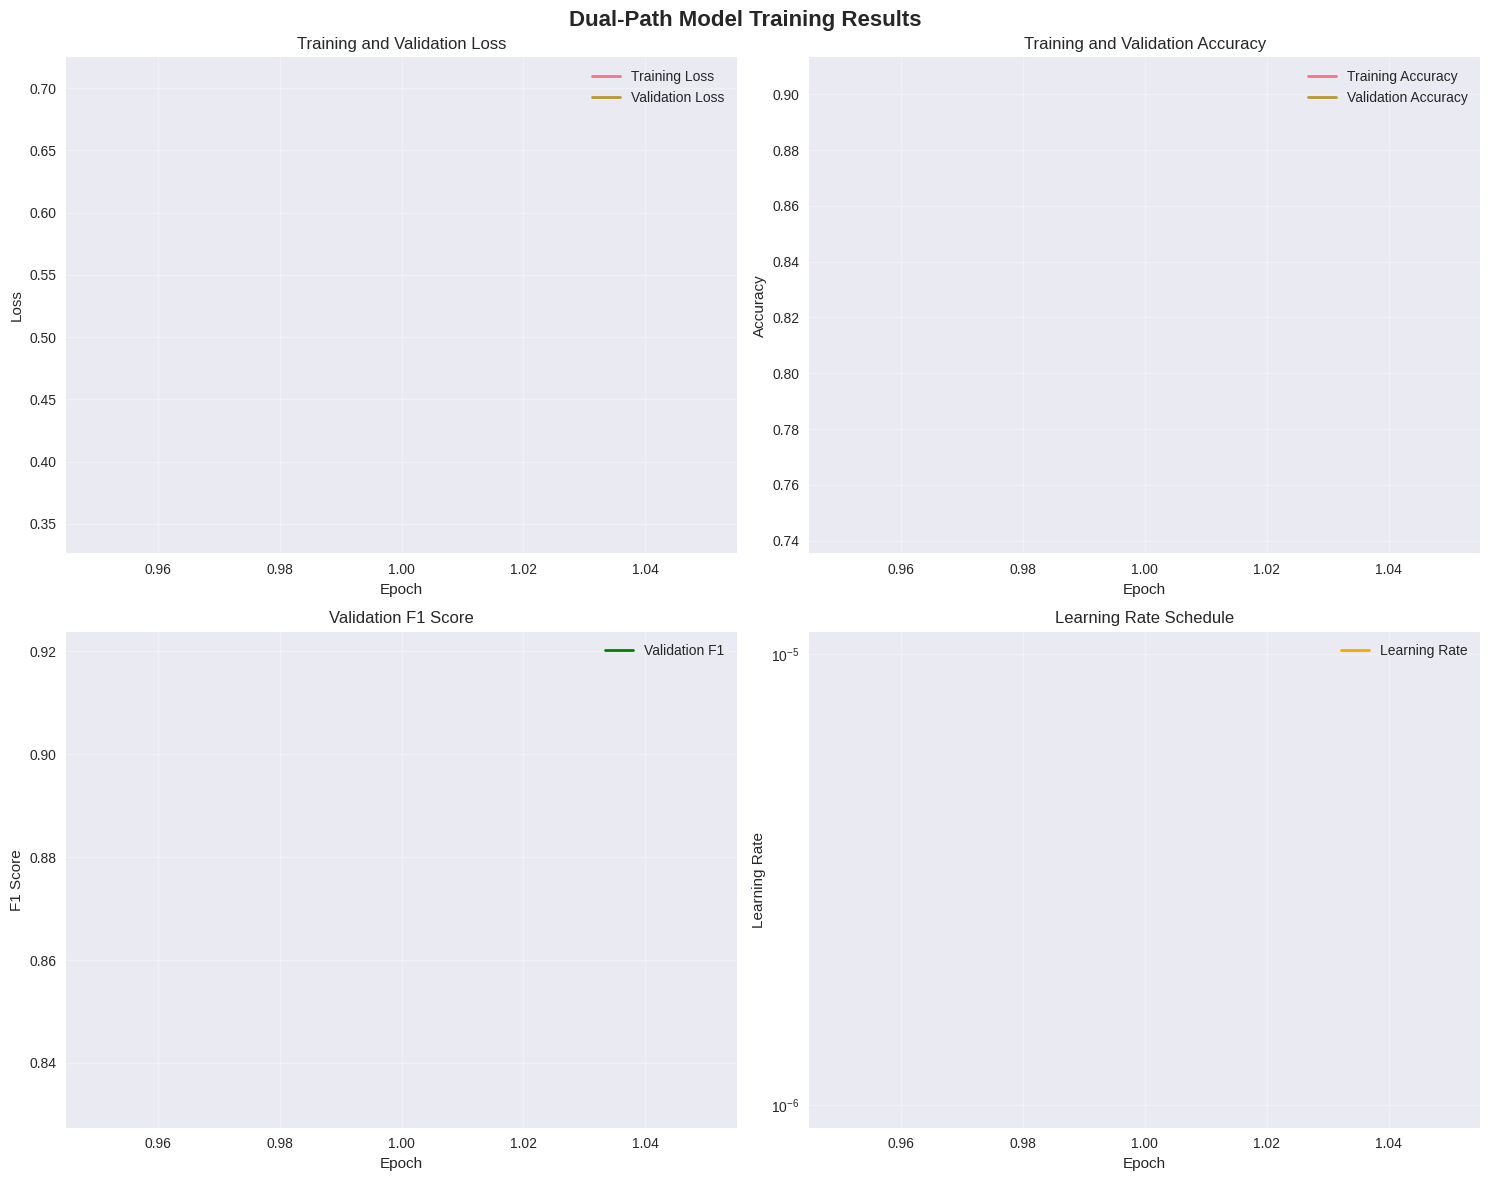


Final Training Metrics:
  Train Loss: 0.7065
  Train Accuracy: 0.7436
  Val Loss: 0.3445
  Val Accuracy: 0.9052
  Val F1: 0.8756

Best Performance:
  Best Epoch: 1
  Best Val F1: 0.8756
  Best Val Accuracy: 0.9052


In [21]:
# Training Results Visualization
if history is not None:
    print("=" * 60)
    print("TRAINING RESULTS")
    print("=" * 60)
    
    # Create comprehensive training plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Dual-Path Model Training Results', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    axes[0, 0].plot(epochs, history['train_loss'], label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[0, 1].plot(epochs, history['train_acc'], label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, history['val_acc'], label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 Score plot
    axes[1, 0].plot(epochs, history['val_f1'], label='Validation F1', color='green', linewidth=2)
    axes[1, 0].set_title('Validation F1 Score')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning rate plot
    axes[1, 1].plot(epochs, history['learning_rate'], label='Learning Rate', color='orange', linewidth=2)
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print(f"\nFinal Training Metrics:")
    print(f"  Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"  Train Accuracy: {history['train_acc'][-1]:.4f}")
    print(f"  Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"  Val Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"  Val F1: {history['val_f1'][-1]:.4f}")
    
    # Best epoch information
    best_epoch = np.argmax(history['val_f1']) + 1
    best_f1 = max(history['val_f1'])
    best_val_acc = history['val_acc'][best_epoch - 1]
    
    print(f"\nBest Performance:")
    print(f"  Best Epoch: {best_epoch}")
    print(f"  Best Val F1: {best_f1:.4f}")
    print(f"  Best Val Accuracy: {best_val_acc:.4f}")
    
else:
    print("No training history available for visualization")

In [48]:

# Quick Model Evaluation on Test Set
if trainer is not None and datasets is not None:
    print("=" * 60)
    print("QUICK TEST SET EVALUATION")
    print("=" * 60)
    
    # Create test dataloader
    test_loader = dataloaders['test']
    
    print("Evaluating trained model on test set...")
    print("This provides a quick performance overview before detailed evaluation.")
    
    # Evaluate model
    model.eval()
    all_targets = []
    all_predictions = []
    all_probabilities = []
    all_uncertainties = []
    all_epistemic = []
    all_aleatoric = []
    all_evidence = []
    all_alpha = []
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(test_loader):
            images, targets = images.to(device), targets.to(device)
            
            # Get evidential predictions
            evidential_output, confidence = model(images, use_evidential=True)
            probabilities = evidential_output['prob']
            uncertainties = evidential_output['uncertainty']
            alpha = evidential_output['alpha']
            epistemic = evidential_output.get('epistemic', uncertainties)
            aleatoric = evidential_output.get('aleatoric', torch.zeros_like(uncertainties))
            evidence = evidential_output.get('evidence', torch.zeros_like(probabilities))
            predicted = thresholded_predictions(probabilities)
            
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_uncertainties.extend(uncertainties.cpu().numpy())
            all_epistemic.extend(epistemic.cpu().numpy())
            all_aleatoric.extend(aleatoric.cpu().numpy())
            all_evidence.extend(evidence.cpu().numpy())
            all_alpha.extend(alpha.cpu().numpy())
            if batch_idx % 10 == 0:
                print(f"  Processed {batch_idx + 1}/{len(test_loader)} batches")
    
    # Compute comprehensive metrics
    test_metrics = compute_metrics(
        np.array(all_targets),
        np.array(all_predictions),
        np.array(all_probabilities)
    )
    
    # Compute evidential metrics with complete information
    evidential_dict = {
        'prob': torch.tensor(all_probabilities),
        'uncertainty': torch.tensor(all_uncertainties),
        'epistemic': torch.tensor(all_epistemic),
        'aleatoric': torch.tensor(all_aleatoric),
        'alpha': torch.tensor(all_evidence) + 1.0  # Convert evidence to alpha
    }
    
    evidential_metrics = compute_evidential_metrics(
        evidential_dict,
        torch.tensor(all_targets)
    )
    
    print(f"\nTest Set Results:")
    print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"  Macro F1: {test_metrics['macro_f1']:.4f}")
    print(f"  Macro Precision: {test_metrics['macro_precision']:.4f}")
    print(f"  Macro Recall: {test_metrics['macro_recall']:.4f}")
    
    if 'macro_youden_index' in test_metrics:
        print(f"  Youden Index: {test_metrics['macro_youden_index']:.4f}")
    
    print(f"\n🔬 Uncertainty Metrics:")
    print(f"  Average Total Uncertainty: {evidential_metrics['avg_uncertainty']:.4f}")
    print(f"  Average Epistemic Uncertainty: {evidential_metrics['avg_epistemic']:.4f}")
    print(f"  Average Aleatoric Uncertainty: {evidential_metrics['avg_aleatoric']:.4f}")
    print(f"  Average Confidence: {evidential_metrics['avg_confidence']:.4f}")
    print(f"  Average Precision (Evidence): {evidential_metrics['avg_precision']:.4f}")
    print(f"  Uncertainty (Correct): {evidential_metrics['uncertainty_correct']:.4f}")
    print(f"  Uncertainty (Incorrect): {evidential_metrics['uncertainty_incorrect']:.4f}")
    
    print(f"\nPer-Class Results:")
    for class_name in CLASS_NAMES:
        if class_name in test_metrics['per_class_metrics']:
            metrics = test_metrics['per_class_metrics'][class_name]
            print(f"  {class_name}:")
            print(f"    Precision: {metrics['precision']:.4f}")
            print(f"    Recall: {metrics['recall']:.4f}")
            print(f"    F1: {metrics['f1']:.4f}")
            if 'youden_index' in metrics:
                print(f"    Youden Index: {metrics['youden_index']:.4f}")
    
    print("\nQuick evaluation completed!")
    print("For detailed analysis, see the evaluation notebook.")
    
else:
    print("Cannot perform evaluation - trainer or datasets not available")

QUICK TEST SET EVALUATION
Evaluating trained model on test set...
This provides a quick performance overview before detailed evaluation.
  Processed 1/59 batches
  Processed 11/59 batches
  Processed 21/59 batches
  Processed 31/59 batches
  Processed 41/59 batches
  Processed 51/59 batches

Test Set Results:
  Accuracy: 0.8950
  Macro F1: 0.8684
  Macro Precision: 0.8671
  Macro Recall: 0.8700
  Youden Index: 0.8743

🔬 Uncertainty Metrics:
  Average Total Uncertainty: 0.0158
  Average Epistemic Uncertainty: 0.0158
  Average Aleatoric Uncertainty: 0.5504
  Average Confidence: 0.7910
  Average Precision (Evidence): 1555.0583
  Uncertainty (Correct): 0.0137
  Uncertainty (Incorrect): 0.0340

Per-Class Results:
  Cyst:
    Precision: 0.9209
    Recall: 0.9209
    F1: 0.9209
    Youden Index: 0.9153
  Normal:
    Precision: 0.9318
    Recall: 0.9318
    F1: 0.9318
    Youden Index: 0.9028
  Stone:
    Precision: 0.7604
    Recall: 0.7971
    F1: 0.7783
    Youden Index: 0.8323
  Tumor:
   

In [49]:
# Save Final Model and Configuration
if trainer is not None:
    print("=" * 60)
    print("SAVING MODEL AND CONFIGURATION")
    print("=" * 60)
    
    # Create save directory
    save_dir = Path('checkpoints/dual_path_evidential')
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Save final model
    final_model_path = save_dir / 'final_model.pth'
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved: {final_model_path}")
    
    # Save model configuration
    model_config = {
        'model_type': 'full',
        'architecture': 'DualPathKidneyClassifier',
        'input_size': MODEL_CONFIG['input_size'],
        'num_classes': NUM_CLASSES,
        'class_names': CLASS_NAMES,
        'feature_dim': MODEL_CONFIG['feature_dim'],
        'attention_dim': MODEL_CONFIG['attention_dim'],
        'evidential_enabled': True,
        'evidence_activation': MODEL_CONFIG.get('evidence_activation', 'exp')
    }
    
    config_path = save_dir / 'model_config.json'
    with open(config_path, 'w') as f:
        json.dump(model_config, f, indent=2)
    print(f"Model configuration saved: {config_path}")
    
    # Save training configuration
    training_config = {
        'num_epochs': TRAINING_CONFIG['num_epochs'],
        'batch_size': TRAINING_CONFIG['batch_size'],
        'learning_rate': TRAINING_CONFIG['learning_rate'],
        'weight_decay': TRAINING_CONFIG['weight_decay'],
        'loss_type': 'evidential',
        'freezing_enabled': FREEZING_CONFIG['enabled'],
        'class_weights': CLASS_WEIGHTS,
        'class_thresholds': CLASS_THRESHOLDS
    }
    
    training_config_path = save_dir / 'training_config.json'
    with open(training_config_path, 'w') as f:
        json.dump(training_config, f, indent=2)
    print(f"Training configuration saved: {training_config_path}")
    
    # Save class information
    class_info = {
        'class_names': CLASS_NAMES,
        'num_classes': NUM_CLASSES,
        'class_weights': CLASS_WEIGHTS,
        'class_thresholds': CLASS_THRESHOLDS
    }
    
    class_info_path = save_dir / 'class_info.json'
    with open(class_info_path, 'w') as f:
        json.dump(class_info, f, indent=2)
    print(f"Class information saved: {class_info_path}")
    
    print(f"\nAll files saved in: {save_dir}")
    print(f"Model ready for detailed evaluation and deployment!")
    
else:
    print("Cannot save model - training not completed")

SAVING MODEL AND CONFIGURATION
Final model saved: checkpoints/dual_path_evidential/final_model.pth
Model configuration saved: checkpoints/dual_path_evidential/model_config.json
Training configuration saved: checkpoints/dual_path_evidential/training_config.json
Class information saved: checkpoints/dual_path_evidential/class_info.json

All files saved in: checkpoints/dual_path_evidential
Model ready for detailed evaluation and deployment!


## Training Summary

This training notebook has successfully:

1. **Configured the dual-path architecture** with EfficientNet-B4 and lightweight CNN
2. **Implemented evidential learning** for uncertainty quantification
3. **Applied clinical optimization** with class weights and thresholds
4. **Executed training** with comprehensive monitoring
5. **Visualized results** with detailed plots and metrics
6. **Performed quick evaluation** on test set
7. **Saved model and configurations** for deployment

## Next Steps

1. **Run the evaluation notebook** for detailed analysis
2. **Perform ablation studies** to understand component contributions
3. **Conduct uncertainty analysis** to validate evidential learning
4. **Deploy model** for clinical testing

## Key Features Implemented

- **Evidential Learning**: Dirichlet-based uncertainty with epistemic/aleatoric separation
- **Cross-Attention Fusion**: Dynamic integration of global and local features
- **Clinical Optimization**: Priority-aware training for medical applications
- **Comprehensive Monitoring**: Loss, accuracy, F1, uncertainty metrics
- **Youden Index**: Optimal threshold selection for clinical decision-making

The model is now ready for detailed evaluation and clinical deployment!

# Dual-Path Kidney Classification - Detailed Evaluation

## Evaluation Components

### 🔬 **Model Performance Analysis**
- Standard classification metrics (Accuracy, Precision, Recall, F1)
- ROC-AUC analysis with class-specific curves
- Precision-Recall curves for imbalanced classes
- Confusion matrix with clinical interpretations

### **Clinical Performance Evaluation**
- **Youden Index**: Optimal threshold selection for clinical decision-making
- **Sensitivity/Specificity** trade-offs for each condition
- **Clinical Priority Analysis**: Tumor recall vs Normal precision
- **Threshold Optimization**: Class-specific clinical thresholds

### 🔍 **Uncertainty Quantification Analysis**
- **Evidential Learning**: Dirichlet parameter analysis
- **Epistemic vs Aleatoric** uncertainty separation
- **Calibration Analysis**: Reliability diagrams and ECE
- **Uncertainty-Performance Correlation**: Confidence vs accuracy

### 🧪 **Advanced Diagnostics**
- **Error Analysis**: Misclassification patterns
- **Feature Importance**: Attention visualization
- **Ablation Results**: Component contribution analysis
- **Robustness Testing**: Augmentation and noise analysis

### **Clinical Deployment Readiness**
- **Decision Support**: Confidence-based recommendations
- **Risk Stratification**: Uncertainty-guided referrals
- **Performance Benchmarks**: Comparison with clinical standards

In [50]:
# Import Required Libraries
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import pickle
from scipy import stats
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True


In [51]:
# Import Project Modules and Load Configuration
from config import *
from models import create_model, DualPathKidneyClassifier
from utils import compute_metrics, thresholded_predictions, plot_confusion_matrix
from evidential import compute_evidential_metrics
from dataloader import create_datasets, create_dataloaders

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("Project modules imported successfully!")
print(f"Classes: {CLASS_NAMES}")
print(f"Number of classes: {NUM_CLASSES}")

Using device: cuda
Project modules imported successfully!
Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Number of classes: 4


In [52]:
# Load Trained Model and Configuration
print("=" * 60)
print("LOADING TRAINED MODEL")
print("=" * 60)

model_dir = Path('checkpoints/dual_path_evidential')

# Check if model exists
if not model_dir.exists():
    print(f"Model directory not found: {model_dir}")
    print("Please run the training notebook first!")
    model = None
else:
    # Load model configuration
    config_path = model_dir / 'model_config.json'
    if config_path.exists():
        with open(config_path, 'r') as f:
            model_config = json.load(f)
        print("Model configuration loaded")
        for key, value in model_config.items():
            print(f"  {key}: {value}")
    else:
        print("Model configuration not found, using defaults")
        model_config = {'model_type': 'full'}
    
    # Create and load model
    try:
        model = create_model(model_config.get('model_type', 'full'))
        model = model.to(device)
        
        # Load trained weights
        model_path = model_dir / 'final_model.pth'
        if model_path.exists():
            model.load_state_dict(torch.load(model_path, map_location=device))
            print(f"Model weights loaded from: {model_path}")
        else:
            print(f"Model weights not found: {model_path}")
            model = None
            
    except Exception as e:
        print(f"Error loading model: {e}")
        model = None

# Load training history if available
history_path = model_dir / 'training_history.pkl'
if history_path.exists():
    with open(history_path, 'rb') as f:
        training_history = pickle.load(f)
    print(f"Training history loaded")
else:
    print(f"Training history not found")
    training_history = None

LOADING TRAINED MODEL
Model configuration loaded
  model_type: full
  architecture: DualPathKidneyClassifier
  input_size: 380
  num_classes: 4
  class_names: ['Cyst', 'Normal', 'Stone', 'Tumor']
  feature_dim: 512
  attention_dim: 256
  evidential_enabled: True
  evidence_activation: exp
Model weights loaded from: checkpoints/dual_path_evidential/final_model.pth
Training history loaded


In [53]:
# Load Dataset for Evaluation
print("=" * 60)
print("LOADING EVALUATION DATASET")
print("=" * 60)

# DATA_DIR = "../CT-KIDNEY-DATASET-Normal"  # Update this path to your dataset

if os.path.exists(DATA_DIR):
    print(f"Loading datasets from: {DATA_DIR}")
    
    # Create datasets
    datasets = create_datasets(DATA_DIR)
    dataloaders = create_dataloaders(datasets, batch_size=32)  # Larger batch for evaluation
    
    # Display dataset information
    for split_name, dataset in datasets.items():
        print(f"{split_name}: {len(dataset)} samples")
    
    print("Datasets loaded successfully")
    
else:
    print(f"Dataset directory not found: {DATA_DIR}")
    datasets = None
    dataloaders = None

LOADING EVALUATION DATASET
Loading datasets from: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone
Found class directories: ['Cyst', 'Normal', 'Stone', 'Tumor']
  Cyst: 3709 images
  Normal: 5077 images
  Stone: 1377 images
  Tumor: 2283 images

Total loaded: 12446 images from 4 classes

Data splits:
  train: 8712 samples
    Cyst: 2597
    Normal: 3553
    Stone: 964
    Tumor: 1598
  val: 1867 samples
    Cyst: 556
    Normal: 762
    Stone: 206
    Tumor: 343
  test: 1867 samples
    Cyst: 556
    Normal: 762
    Stone: 207
    Tumor: 342
train: 8712 samples
val: 1867 samples
test: 1867 samples
Datasets loaded successfully


In [57]:
# Comprehensive Model Evaluation
def evaluate_model_comprehensive(model, dataloader, device, class_names):
    """Perform comprehensive model evaluation with evidential outputs."""
    model.eval()
    
    all_targets = []
    all_predictions = []
    all_probabilities = []
    all_uncertainties = []
    all_epistemic = []
    all_aleatoric = []
    all_confidence = []
    all_evidence = []
    all_alpha = []
    print("Performing comprehensive evaluation...")
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dataloader):
            images, targets = images.to(device), targets.to(device)
            
            # Get evidential predictions
            evidential_output, confidence = model(images, use_evidential=True)
            
            probabilities = evidential_output['prob']
            uncertainties = evidential_output['uncertainty'] 
            epistemic = evidential_output['epistemic']
            aleatoric = evidential_output['aleatoric']
            evidence = evidential_output['evidence']
            alpha = evidential_output['alpha']
            predicted = thresholded_predictions(probabilities)
            
            # Store results
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_uncertainties.extend(uncertainties.cpu().numpy())
            all_epistemic.extend(epistemic.cpu().numpy())
            all_aleatoric.extend(aleatoric.cpu().numpy())
            all_confidence.extend(confidence.cpu().numpy())
            all_evidence.extend(evidence.cpu().numpy())
            all_alpha.extend(alpha.cpu().numpy())
            if (batch_idx + 1) % 20 == 0:
                print(f"  Processed {batch_idx + 1}/{len(dataloader)} batches")
    
    # Convert to numpy arrays
    results = {
        'targets': np.array(all_targets),
        'predictions': np.array(all_predictions),
        'probabilities': np.array(all_probabilities),
        'uncertainties': np.array(all_uncertainties).flatten(),
        'epistemic': np.array(all_epistemic).flatten(),
        'aleatoric': np.array(all_aleatoric).flatten(),
        'confidence': np.array(all_confidence).flatten(),
        'evidence': np.array(all_evidence),
        'alpha': np.array(alpha.cpu())
    }
    
    print(f"Evaluation completed on {len(all_targets)} samples")
    return results

# Perform evaluation if model and data are available
if model is not None and dataloaders is not None:
    print("Starting comprehensive evaluation...")
    
    # Evaluate on test set
    test_results = evaluate_model_comprehensive(
        model, dataloaders['test'], device, CLASS_NAMES
    )
    
    # Evaluate on validation set for comparison
    val_results = evaluate_model_comprehensive(
        model, dataloaders['val'], device, CLASS_NAMES
    )
    
    print("Comprehensive evaluation completed!")
    
else:
    print("Cannot perform evaluation - model or data not available")
    test_results = None
    val_results = None

Starting comprehensive evaluation...
Performing comprehensive evaluation...
  Processed 20/59 batches
  Processed 40/59 batches
Evaluation completed on 1867 samples
Performing comprehensive evaluation...
  Processed 20/59 batches
  Processed 40/59 batches
Evaluation completed on 1867 samples
Comprehensive evaluation completed!


In [58]:
evidential_output['prob'].size()

torch.Size([11, 4])

In [59]:
# Standard Classification Metrics
if test_results is not None:
    print("=" * 60)
    print("STANDARD CLASSIFICATION METRICS")
    print("=" * 60)
    
    # Compute comprehensive metrics
    test_metrics = compute_metrics(
        test_results['targets'],
        test_results['predictions'], 
        test_results['probabilities']
    )
    
    # Display overall metrics
    print("Overall Performance:")
    print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"  Macro F1: {test_metrics['macro_f1']:.4f}")
    print(f"  Macro Precision: {test_metrics['macro_precision']:.4f}")
    print(f"  Macro Recall: {test_metrics['macro_recall']:.4f}")
    print(f"  Weighted F1: {test_metrics['weighted_f1']:.4f}")
    
    if 'macro_roc_auc' in test_metrics:
        print(f"  Macro ROC-AUC: {test_metrics['macro_roc_auc']:.4f}")
    
    if 'macro_youden_index' in test_metrics:
        print(f"  Macro Youden Index: {test_metrics['macro_youden_index']:.4f}")
    
    # Per-class metrics table
    print(f"\nPer-Class Performance:")
    
    class_data = []
    for class_name in CLASS_NAMES:
        if class_name in test_metrics['per_class_metrics']:
            metrics = test_metrics['per_class_metrics'][class_name]
            class_data.append({
                'Class': class_name,
                'Precision': f"{metrics['precision']:.4f}",
                'Recall': f"{metrics['recall']:.4f}",
                'F1-Score': f"{metrics['f1']:.4f}",
                'Support': int(metrics['support']),
                'ROC-AUC': f"{metrics.get('roc_auc', 0):.4f}",
                'Youden Index': f"{metrics.get('youden_index', 0):.4f}"
            })
    
    df_metrics = pd.DataFrame(class_data)
    print(df_metrics.to_string(index=False))
    
    # Classification report
    print(f"\nDetailed Classification Report:")
    report = classification_report(
        test_results['targets'], 
        test_results['predictions'], 
        target_names=CLASS_NAMES,
        digits=4
    )
    print(report)

STANDARD CLASSIFICATION METRICS
Overall Performance:
  Accuracy: 0.8950
  Macro F1: 0.8684
  Macro Precision: 0.8671
  Macro Recall: 0.8700
  Weighted F1: 0.8952
  Macro ROC-AUC: 0.9800
  Macro Youden Index: 0.8743

Per-Class Performance:
 Class Precision Recall F1-Score  Support ROC-AUC Youden Index
  Cyst    0.9209 0.9209   0.9209      556  0.9878       0.9153
Normal    0.9318 0.9318   0.9318      762  0.9892       0.9028
 Stone    0.7604 0.7971   0.7783      207  0.9656       0.8323
 Tumor    0.8554 0.8304   0.8427      342  0.9773       0.8466

Detailed Classification Report:
              precision    recall  f1-score   support

        Cyst     0.9209    0.9209    0.9209       556
      Normal     0.9318    0.9318    0.9318       762
       Stone     0.7604    0.7971    0.7783       207
       Tumor     0.8554    0.8304    0.8427       342

    accuracy                         0.8950      1867
   macro avg     0.8671    0.8700    0.8684      1867
weighted avg     0.8955    0.8950

CONFUSION MATRIX ANALYSIS


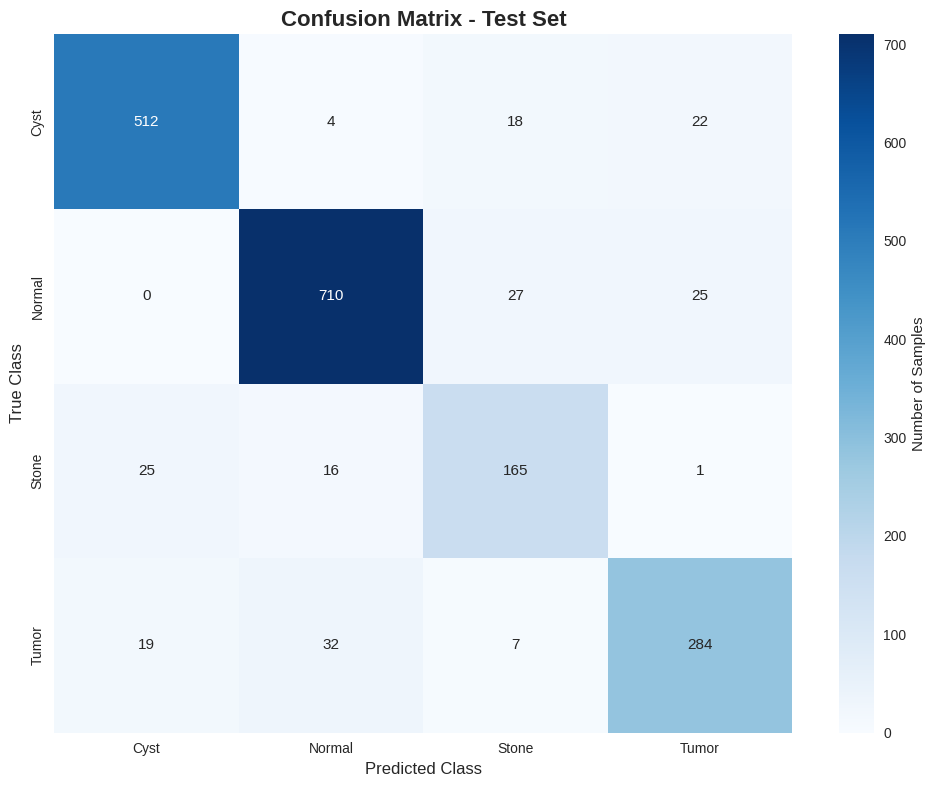

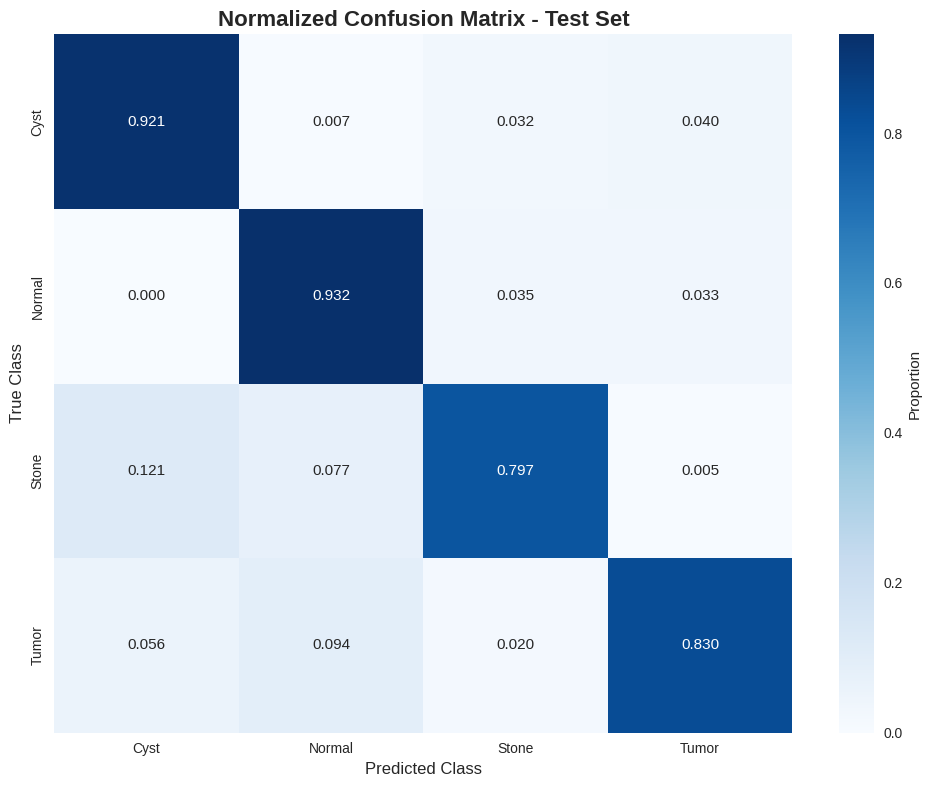

Clinical Interpretation:

  Cyst:
    Sensitivity (Recall): 0.9209
    Specificity: 0.9664
    PPV (Precision): 0.9209
    NPV: 0.9664

  Normal:
    Sensitivity (Recall): 0.9318
    Specificity: 0.9529
    PPV (Precision): 0.9318
    NPV: 0.9529
    High specificity important to avoid false alarms

  Stone:
    Sensitivity (Recall): 0.7971
    Specificity: 0.9687
    PPV (Precision): 0.7604
    NPV: 0.9745

  Tumor:
    Sensitivity (Recall): 0.8304
    Specificity: 0.9685
    PPV (Precision): 0.8554
    NPV: 0.9622
    High sensitivity critical for tumor detection
ROC CURVE ANALYSIS


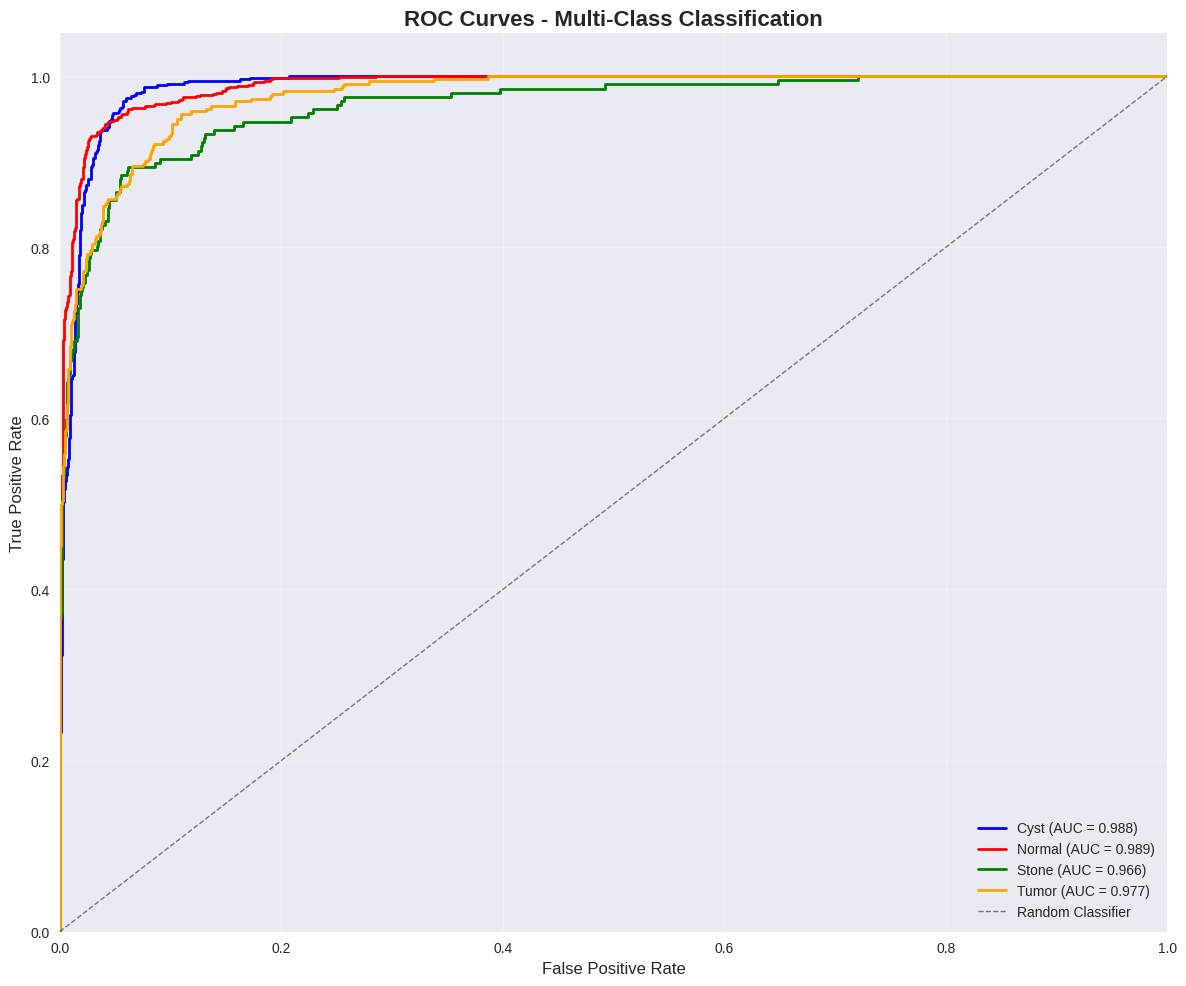

ROC-AUC Summary:
  Macro-average AUC: 0.9800
  Cyst: 0.9878
  Normal: 0.9892
  Stone: 0.9656
  Tumor: 0.9773

Clinical Priority Analysis:
  Tumor detection AUC: 0.9773 ✅
  Normal classification AUC: 0.9892 ✅


In [60]:
# Confusion Matrix Analysis
if test_results is not None:
    print("=" * 60)
    print("CONFUSION MATRIX ANALYSIS")
    print("=" * 60)
    
    # Create confusion matrix
    cm = confusion_matrix(test_results['targets'], test_results['predictions'])
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
                cbar_kws={'label': 'Number of Samples'})
    plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
                cbar_kws={'label': 'Proportion'})
    plt.title('Normalized Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Clinical interpretation
    print("Clinical Interpretation:")
    
    # Calculate sensitivity and specificity for each class
    for i, class_name in enumerate(CLASS_NAMES):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - tp - fn - fp
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        print(f"\n  {class_name}:")
        print(f"    Sensitivity (Recall): {sensitivity:.4f}")
        print(f"    Specificity: {specificity:.4f}")
        print(f"    PPV (Precision): {ppv:.4f}")
        print(f"    NPV: {npv:.4f}")
        
        # Clinical significance
        if class_name == 'Tumor':
            print(f"    High sensitivity critical for tumor detection")
        elif class_name == 'Normal':
            print(f"    High specificity important to avoid false alarms")# ROC Curve Analysis
if test_results is not None:
    print("=" * 60)
    print("ROC CURVE ANALYSIS")
    print("=" * 60)
    
    # Binarize the targets for multiclass ROC
    targets_binarized = label_binarize(test_results['targets'], classes=range(NUM_CLASSES))
    
    # Plot ROC curves for each class
    plt.figure(figsize=(12, 10))
    
    colors = ['blue', 'red', 'green', 'orange']
    auc_scores = []
    
    for i, (class_name, color) in enumerate(zip(CLASS_NAMES, colors)):
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(targets_binarized[:, i], test_results['probabilities'][:, i])
        auc_score = roc_auc_score(targets_binarized[:, i], test_results['probabilities'][:, i])
        auc_scores.append(auc_score)
        
        plt.plot(fpr, tpr, color=color, linewidth=2, 
                label=f'{class_name} (AUC = {auc_score:.3f})')
    
    # Plot random classifier
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Multi-Class Classification', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Macro and micro averages
    macro_auc = np.mean(auc_scores)
    print(f"ROC-AUC Summary:")
    print(f"  Macro-average AUC: {macro_auc:.4f}")
    
    for class_name, auc in zip(CLASS_NAMES, auc_scores):
        print(f"  {class_name}: {auc:.4f}")
    
    # Clinical priority analysis
    print(f"\nClinical Priority Analysis:")
    tumor_auc = auc_scores[CLASS_NAMES.index('Tumor')] if 'Tumor' in CLASS_NAMES else 0
    normal_auc = auc_scores[CLASS_NAMES.index('Normal')] if 'Normal' in CLASS_NAMES else 0
    
    print(f"  Tumor detection AUC: {tumor_auc:.4f} {'✅' if tumor_auc > 0.95 else '⚠️'}")
    print(f"  Normal classification AUC: {normal_auc:.4f} {'✅' if normal_auc > 0.90 else '⚠️'}")

ROC CURVE ANALYSIS


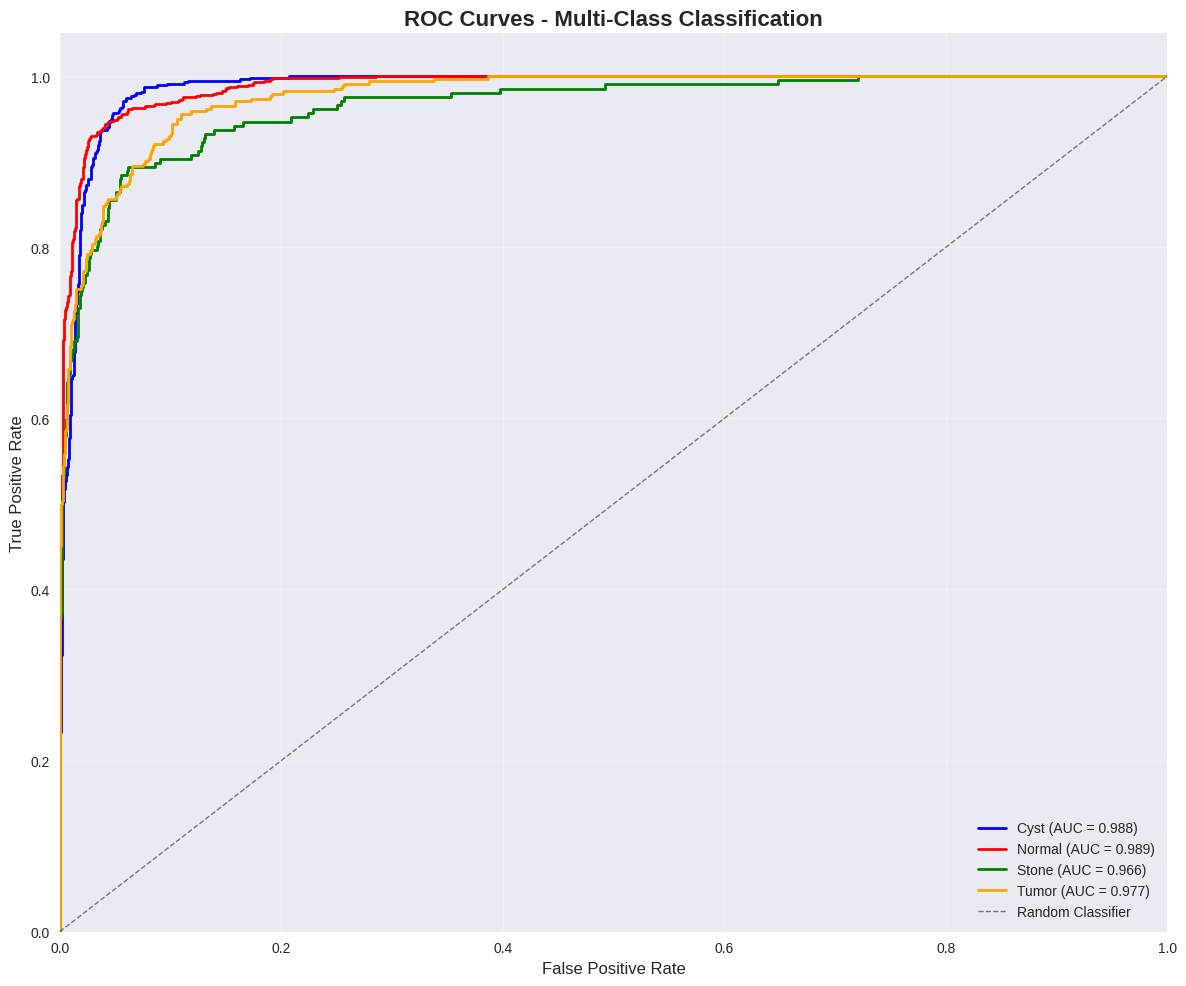

ROC-AUC Summary:
  Macro-average AUC: 0.9800
  Cyst: 0.9878
  Normal: 0.9892
  Stone: 0.9656
  Tumor: 0.9773

Clinical Priority Analysis:
  Tumor detection AUC: 0.9773 ✅
  Normal classification AUC: 0.9892 ✅


In [61]:
# ROC Curve Analysis
if test_results is not None:
    print("=" * 60)
    print("ROC CURVE ANALYSIS")
    print("=" * 60)
    
    # Binarize the targets for multiclass ROC
    targets_binarized = label_binarize(test_results['targets'], classes=range(NUM_CLASSES))
    
    # Plot ROC curves for each class
    plt.figure(figsize=(12, 10))
    
    colors = ['blue', 'red', 'green', 'orange']
    auc_scores = []
    
    for i, (class_name, color) in enumerate(zip(CLASS_NAMES, colors)):
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(targets_binarized[:, i], test_results['probabilities'][:, i])
        auc_score = roc_auc_score(targets_binarized[:, i], test_results['probabilities'][:, i])
        auc_scores.append(auc_score)
        
        plt.plot(fpr, tpr, color=color, linewidth=2, 
                label=f'{class_name} (AUC = {auc_score:.3f})')
    
    # Plot random classifier
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Multi-Class Classification', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Macro and micro averages
    macro_auc = np.mean(auc_scores)
    print(f"ROC-AUC Summary:")
    print(f"  Macro-average AUC: {macro_auc:.4f}")
    
    for class_name, auc in zip(CLASS_NAMES, auc_scores):
        print(f"  {class_name}: {auc:.4f}")
    
    # Clinical priority analysis
    print(f"\nClinical Priority Analysis:")
    tumor_auc = auc_scores[CLASS_NAMES.index('Tumor')] if 'Tumor' in CLASS_NAMES else 0
    normal_auc = auc_scores[CLASS_NAMES.index('Normal')] if 'Normal' in CLASS_NAMES else 0
    
    print(f"  Tumor detection AUC: {tumor_auc:.4f} {'✅' if tumor_auc > 0.95 else '⚠️'}")
    print(f"  Normal classification AUC: {normal_auc:.4f} {'✅' if normal_auc > 0.90 else '⚠️'}")

PRECISION-RECALL CURVE ANALYSIS


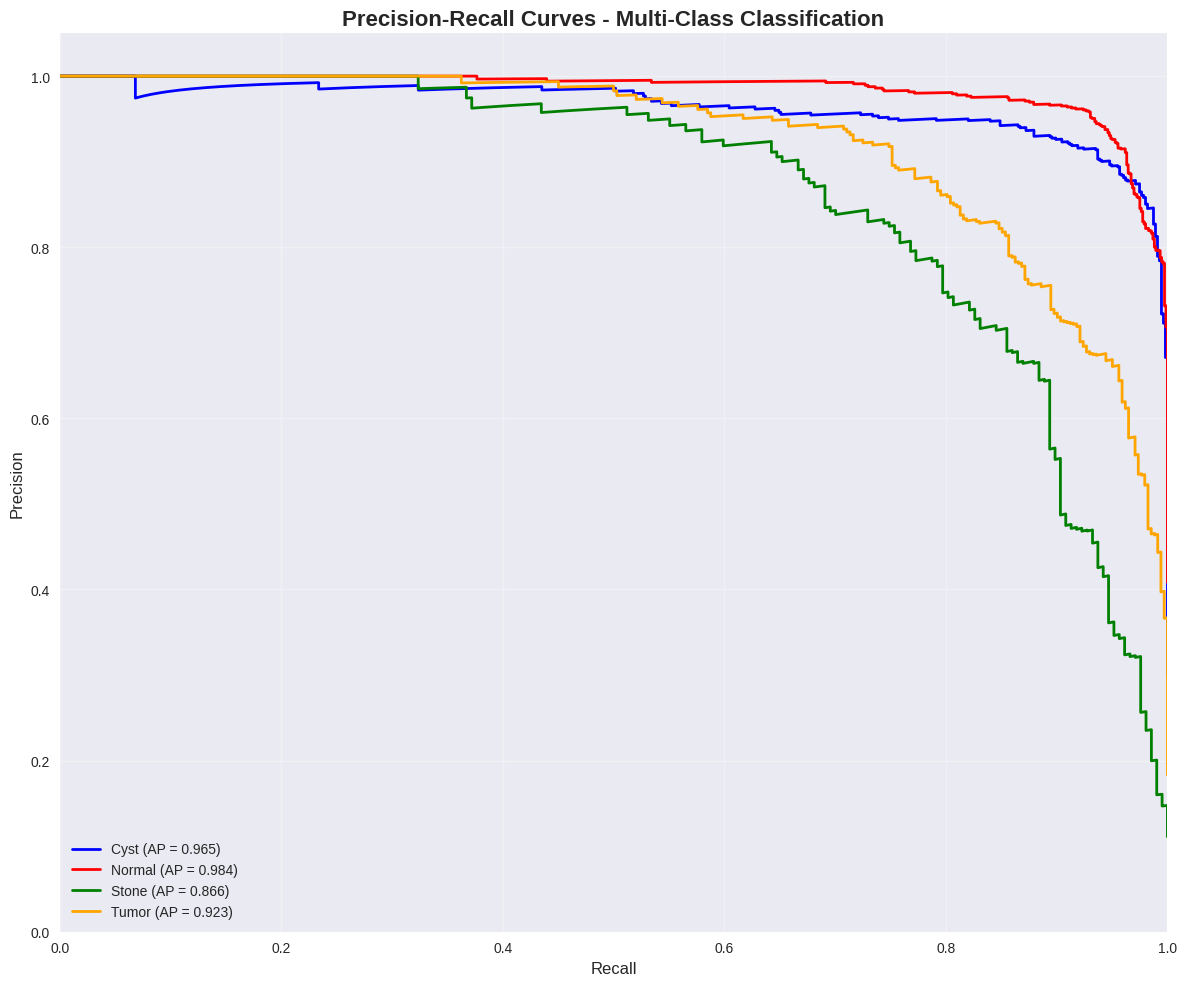

Average Precision Summary:
  Macro-average AP: 0.9344
  Cyst: 0.9646
  Normal: 0.9843
  Stone: 0.8659
  Tumor: 0.9226

⚖️ Class Imbalance Analysis:
  Cyst: 556 samples (29.8%) - AP: 0.9646
  Normal: 762 samples (40.8%) - AP: 0.9843
  Stone: 207 samples (11.1%) - AP: 0.8659
    Good performance on minority class
  Tumor: 342 samples (18.3%) - AP: 0.9226
    Good performance on minority class


In [62]:
# Precision-Recall Curve Analysis
if test_results is not None:
    print("=" * 60)
    print("PRECISION-RECALL CURVE ANALYSIS")
    print("=" * 60)
    
    # Plot PR curves for each class
    plt.figure(figsize=(12, 10))
    
    colors = ['blue', 'red', 'green', 'orange']
    ap_scores = []
    
    for i, (class_name, color) in enumerate(zip(CLASS_NAMES, colors)):
        # Calculate PR curve
        precision, recall, _ = precision_recall_curve(
            targets_binarized[:, i], test_results['probabilities'][:, i]
        )
        ap_score = average_precision_score(
            targets_binarized[:, i], test_results['probabilities'][:, i]
        )
        ap_scores.append(ap_score)
        
        plt.plot(recall, precision, color=color, linewidth=2,
                label=f'{class_name} (AP = {ap_score:.3f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves - Multi-Class Classification', 
              fontsize=16, fontweight='bold')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Average Precision summary
    macro_ap = np.mean(ap_scores)
    print(f"Average Precision Summary:")
    print(f"  Macro-average AP: {macro_ap:.4f}")
    
    for class_name, ap in zip(CLASS_NAMES, ap_scores):
        print(f"  {class_name}: {ap:.4f}")
    
    # Class imbalance analysis
    print(f"\n⚖️ Class Imbalance Analysis:")
    class_counts = np.bincount(test_results['targets'])
    total_samples = len(test_results['targets'])
    
    for i, (class_name, count) in enumerate(zip(CLASS_NAMES, class_counts)):
        percentage = (count / total_samples) * 100
        ap_score = ap_scores[i]
        print(f"  {class_name}: {count} samples ({percentage:.1f}%) - AP: {ap_score:.4f}")
        
        if percentage < 20 and ap_score > 0.8:
            print(f"    Good performance on minority class")
        elif percentage < 20 and ap_score < 0.7:
            print(f"    Consider class balancing techniques")

YOUDEN INDEX & OPTIMAL THRESHOLDS


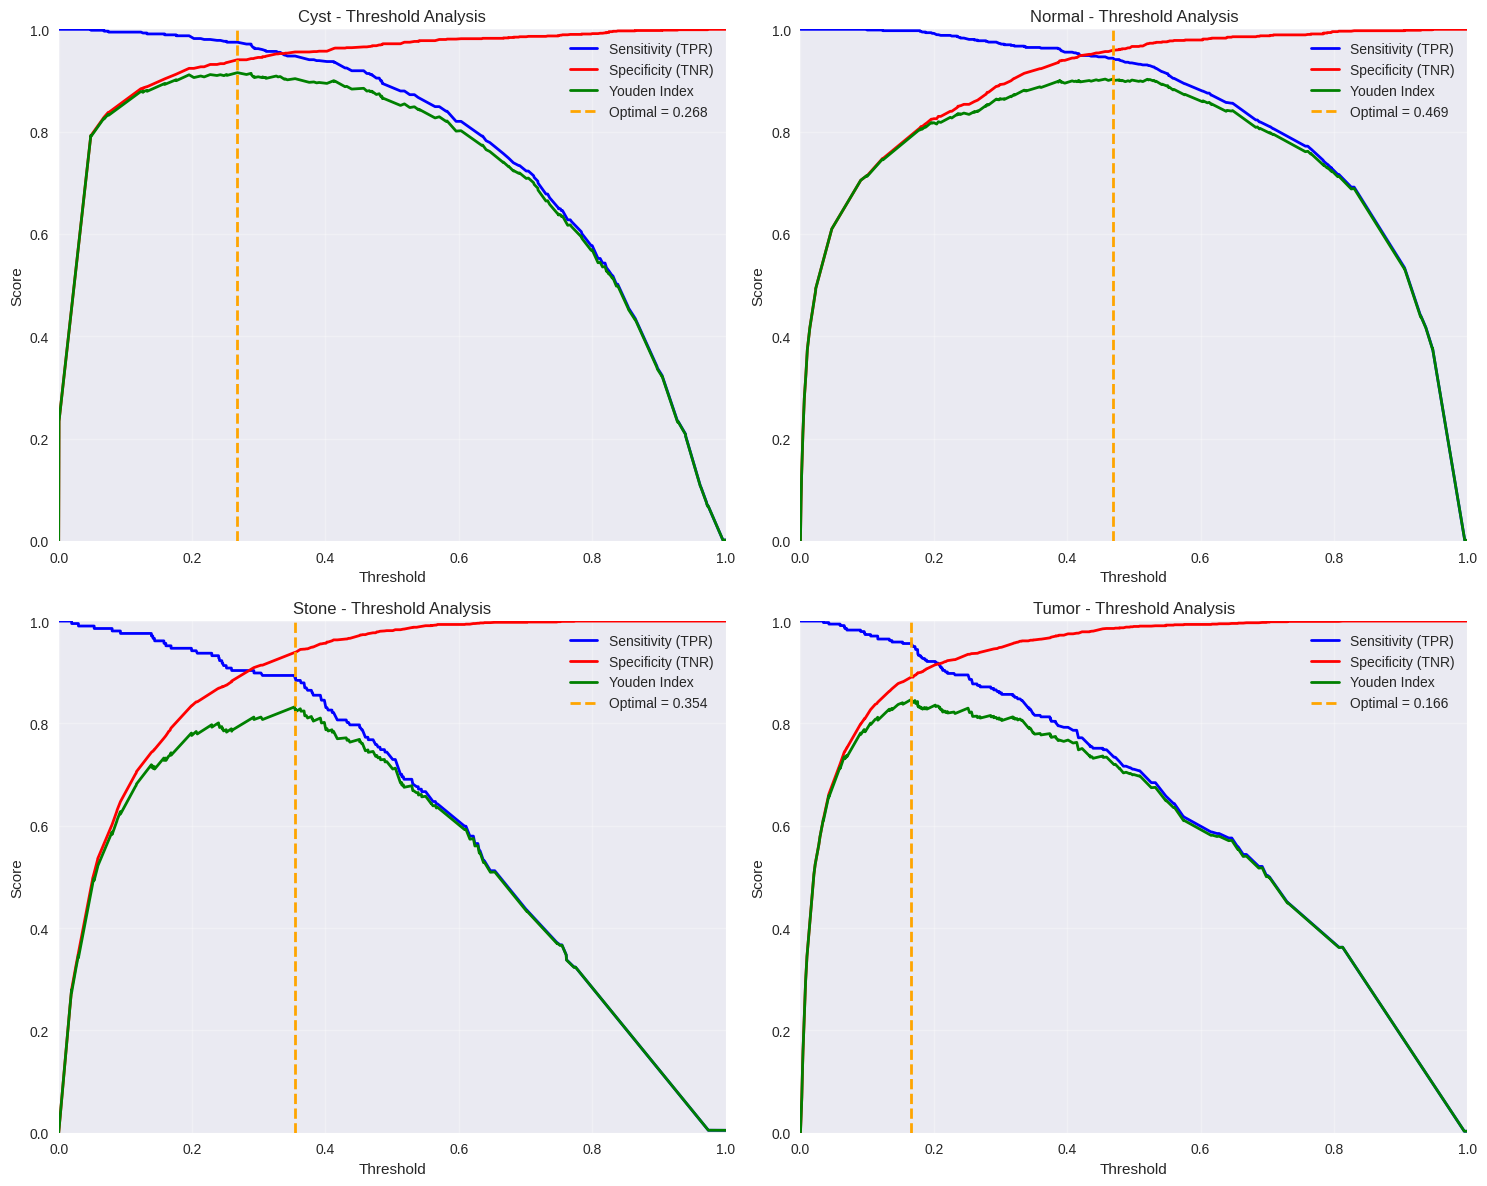

Optimal Thresholds Summary:
 Class Current Threshold Optimal Threshold Youden Index Sensitivity Specificity
  Cyst             0.500             0.268       0.9153      0.9748      0.9405
Normal             0.600             0.469       0.9028      0.9436      0.9593
 Stone             0.500             0.354       0.8323      0.8937      0.9386
 Tumor             0.350             0.166       0.8466      0.9561      0.8905

Clinical Threshold Recommendations:

  Cyst:
    Current: 0.500 → Optimal: 0.268
    💡 Consider updating threshold to 0.268

  Normal:
    Current: 0.600 → Optimal: 0.469
    Good specificity to avoid false alarms (0.959)
    💡 Consider updating threshold to 0.469

  Stone:
    Current: 0.500 → Optimal: 0.354
    💡 Consider updating threshold to 0.354

  Tumor:
    Current: 0.350 → Optimal: 0.166
    Excellent sensitivity for tumor detection (0.956)
    💡 Consider updating threshold to 0.166


In [63]:
# Youden Index and Optimal Thresholds Analysis
if test_results is not None:
    print("=" * 60)
    print("YOUDEN INDEX & OPTIMAL THRESHOLDS")
    print("=" * 60)
    
    # Calculate Youden index for each class
    youden_results = {}
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, class_name in enumerate(CLASS_NAMES):
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(
            targets_binarized[:, i], test_results['probabilities'][:, i]
        )
        
        # Calculate Youden index for each threshold
        youden_indices = tpr - fpr
        optimal_idx = np.argmax(youden_indices)
        optimal_threshold = thresholds[optimal_idx]
        optimal_youden = youden_indices[optimal_idx]
        optimal_sensitivity = tpr[optimal_idx]
        optimal_specificity = 1 - fpr[optimal_idx]
        
        youden_results[class_name] = {
            'optimal_threshold': optimal_threshold,
            'youden_index': optimal_youden,
            'sensitivity': optimal_sensitivity,
            'specificity': optimal_specificity
        }
        
        # Plot threshold analysis
        ax = axes[i]
        ax.plot(thresholds[:len(tpr)], tpr[:], 'b-', label='Sensitivity (TPR)', linewidth=2)
        ax.plot(thresholds[:len(fpr)], 1 - fpr[:], 'r-', label='Specificity (TNR)', linewidth=2)
        ax.plot(thresholds[:len(youden_indices)], youden_indices[:], 'g-', label='Youden Index', linewidth=2)
        ax.axvline(optimal_threshold, color='orange', linestyle='--', 
                  label=f'Optimal = {optimal_threshold:.3f}', linewidth=2)
        
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Score')
        ax.set_title(f'{class_name} - Threshold Analysis')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print(f"Optimal Thresholds Summary:")
    
    threshold_data = []
    for class_name in CLASS_NAMES:
        if class_name in youden_results:
            results = youden_results[class_name]
            current_threshold = CLASS_THRESHOLDS.get(class_name, 0.5)
            
            threshold_data.append({
                'Class': class_name,
                'Current Threshold': f"{current_threshold:.3f}",
                'Optimal Threshold': f"{results['optimal_threshold']:.3f}",
                'Youden Index': f"{results['youden_index']:.4f}",
                'Sensitivity': f"{results['sensitivity']:.4f}",
                'Specificity': f"{results['specificity']:.4f}"
            })
    
    df_thresholds = pd.DataFrame(threshold_data)
    print(df_thresholds.to_string(index=False))
    
    # Clinical recommendations
    print(f"\nClinical Threshold Recommendations:")
    
    for class_name in CLASS_NAMES:
        if class_name in youden_results:
            current = CLASS_THRESHOLDS.get(class_name, 0.5)
            optimal = youden_results[class_name]['optimal_threshold']
            sensitivity = youden_results[class_name]['sensitivity']
            specificity = youden_results[class_name]['specificity']
            
            print(f"\n  {class_name}:")
            print(f"    Current: {current:.3f} → Optimal: {optimal:.3f}")
            
            if class_name == 'Tumor':
                if sensitivity >= 0.95:
                    print(f"    Excellent sensitivity for tumor detection ({sensitivity:.3f})")
                else:
                    print(f"    Consider lowering threshold for higher sensitivity")
                    
            elif class_name == 'Normal':
                if specificity >= 0.90:
                    print(f"    Good specificity to avoid false alarms ({specificity:.3f})")
                else:
                    print(f"    Consider raising threshold for higher specificity")
            
            # Recommendation
            difference = abs(optimal - current)
            if difference > 0.1:
                print(f"    💡 Consider updating threshold to {optimal:.3f}")
            else:
                print(f"    Current threshold is near optimal")

EVIDENTIAL UNCERTAINTY ANALYSIS
🔬 Uncertainty Metrics:
  accuracy: 0.8998
  avg_uncertainty: 0.0158
  avg_epistemic: 0.0158
  avg_aleatoric: 0.5504
  avg_confidence: 0.7910
  avg_precision: 0.0000
  uncertainty_correct: 0.0137
  uncertainty_incorrect: 0.0340


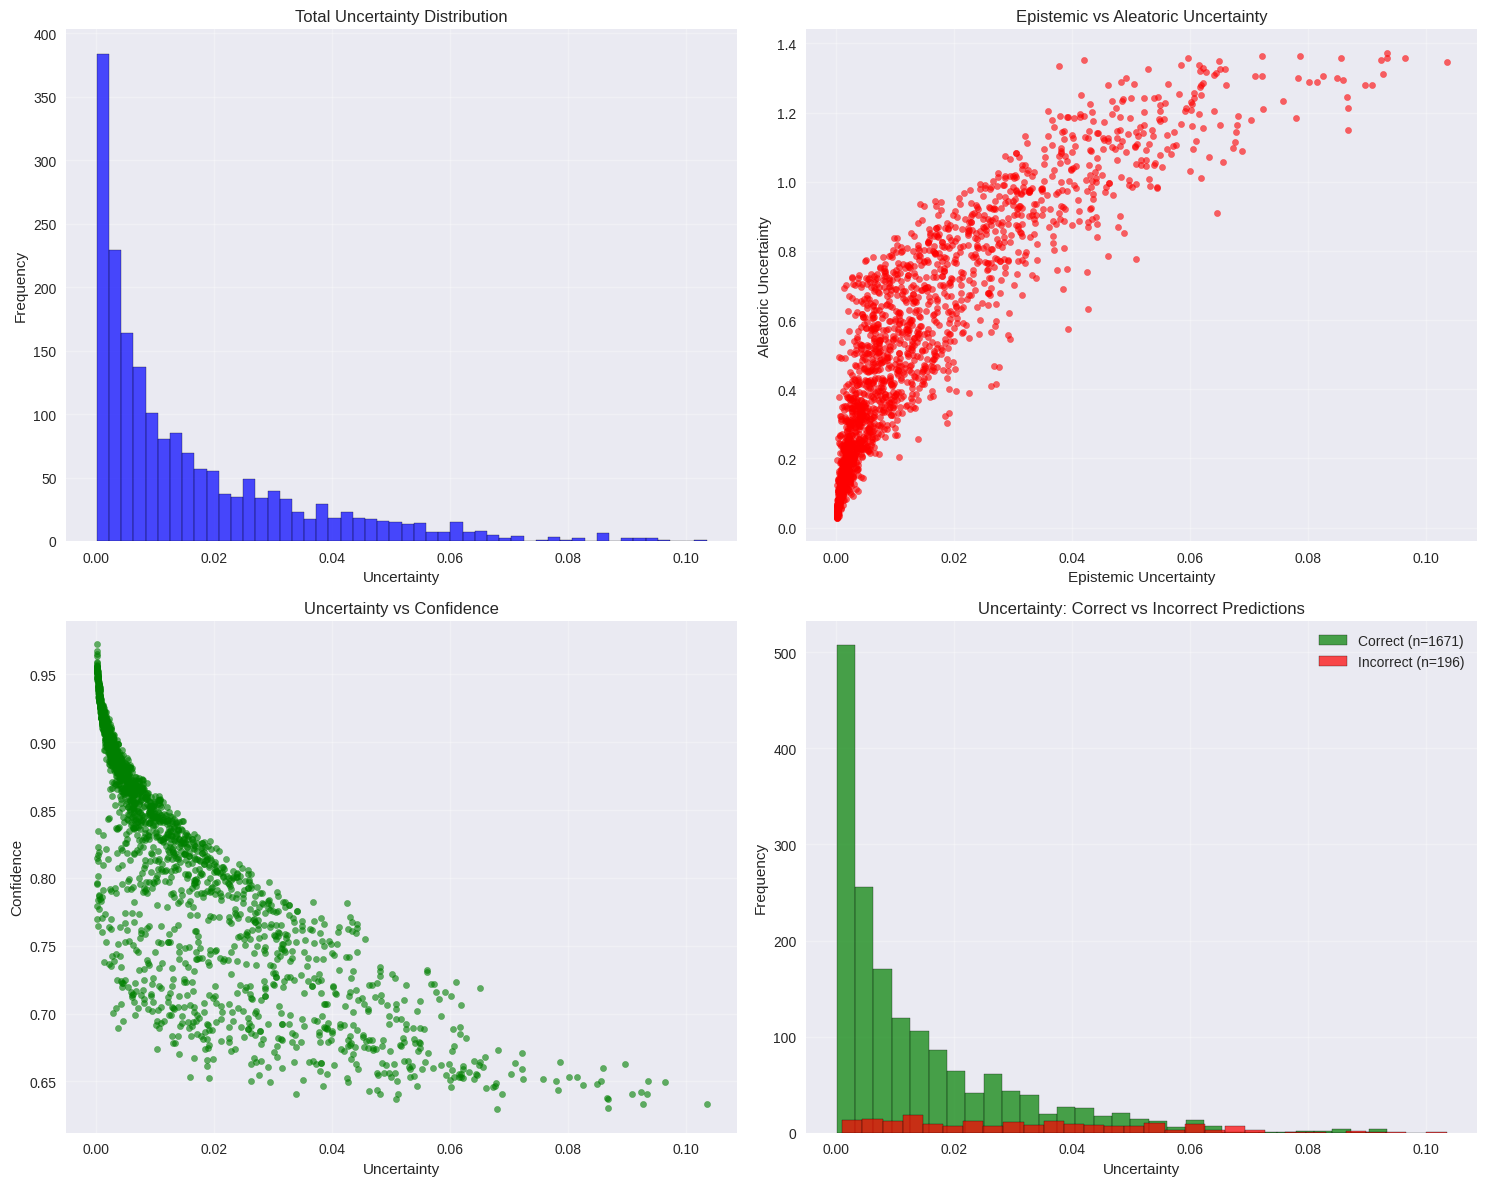


Uncertainty Statistical Analysis:
  Mann-Whitney U test (correct < incorrect uncertainty):
    Statistic: 72468.00, p-value: 0.000000
    Significant: Model assigns higher uncertainty to incorrect predictions

  Average uncertainty by true class:
    Cyst: 0.0165 ± 0.0153
    Normal: 0.0086 ± 0.0136
    Stone: 0.0270 ± 0.0167
    Tumor: 0.0236 ± 0.0219


In [64]:
# Evidential Uncertainty Analysis
if test_results is not None:
    print("=" * 60)
    print("EVIDENTIAL UNCERTAINTY ANALYSIS")
    print("=" * 60)
    
    # Compute evidential metrics
    evidential_output = {
        'prob': torch.tensor(test_results['probabilities']),
        'uncertainty': torch.tensor(test_results['uncertainties']),
        'epistemic': torch.tensor(test_results['epistemic']),
        'aleatoric': torch.tensor(test_results['aleatoric'])
    }
    
    evidential_metrics = compute_evidential_metrics(
        evidential_output, torch.tensor(test_results['targets'])
    )
    
    print("🔬 Uncertainty Metrics:")
    for key, value in evidential_metrics.items():
        print(f"  {key}: {value:.4f}")
    
    # Uncertainty distribution analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Total uncertainty distribution
    axes[0, 0].hist(test_results['uncertainties'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_title('Total Uncertainty Distribution')
    axes[0, 0].set_xlabel('Uncertainty')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Epistemic vs Aleatoric uncertainty
    axes[0, 1].scatter(test_results['epistemic'], test_results['aleatoric'], 
                      alpha=0.6, color='red', s=20)
    axes[0, 1].set_title('Epistemic vs Aleatoric Uncertainty')
    axes[0, 1].set_xlabel('Epistemic Uncertainty')
    axes[0, 1].set_ylabel('Aleatoric Uncertainty')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Uncertainty vs Confidence
    axes[1, 0].scatter(test_results['uncertainties'], test_results['confidence'], 
                      alpha=0.6, color='green', s=20)
    axes[1, 0].set_title('Uncertainty vs Confidence')
    axes[1, 0].set_xlabel('Uncertainty')
    axes[1, 0].set_ylabel('Confidence')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Uncertainty by class
    correct_mask = test_results['predictions'] == test_results['targets']
    correct_uncertainty = test_results['uncertainties'][correct_mask]
    incorrect_uncertainty = test_results['uncertainties'][~correct_mask]
    
    axes[1, 1].hist(correct_uncertainty, bins=30, alpha=0.7, color='green', 
                   label=f'Correct (n={len(correct_uncertainty)})', edgecolor='black')
    axes[1, 1].hist(incorrect_uncertainty, bins=30, alpha=0.7, color='red',
                   label=f'Incorrect (n={len(incorrect_uncertainty)})', edgecolor='black')
    axes[1, 1].set_title('Uncertainty: Correct vs Incorrect Predictions')
    axes[1, 1].set_xlabel('Uncertainty')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print(f"\nUncertainty Statistical Analysis:")
    
    # Uncertainty by prediction correctness
    stat, p_value = stats.mannwhitneyu(correct_uncertainty, incorrect_uncertainty, 
                                      alternative='less')
    print(f"  Mann-Whitney U test (correct < incorrect uncertainty):")
    print(f"    Statistic: {stat:.2f}, p-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print(f"    Significant: Model assigns higher uncertainty to incorrect predictions")
    else:
        print(f"    Not significant: No clear uncertainty-accuracy relationship")
    
    # Uncertainty by class
    print(f"\n  Average uncertainty by true class:")
    for i, class_name in enumerate(CLASS_NAMES):
        class_mask = test_results['targets'] == i
        if class_mask.any():
            class_uncertainty = test_results['uncertainties'][class_mask]
            print(f"    {class_name}: {class_uncertainty.mean():.4f} ± {class_uncertainty.std():.4f}")

In [65]:
if 'prob' not in evidential_output:
    print(1)
else:
    print(2)

2


CALIBRATION ANALYSIS


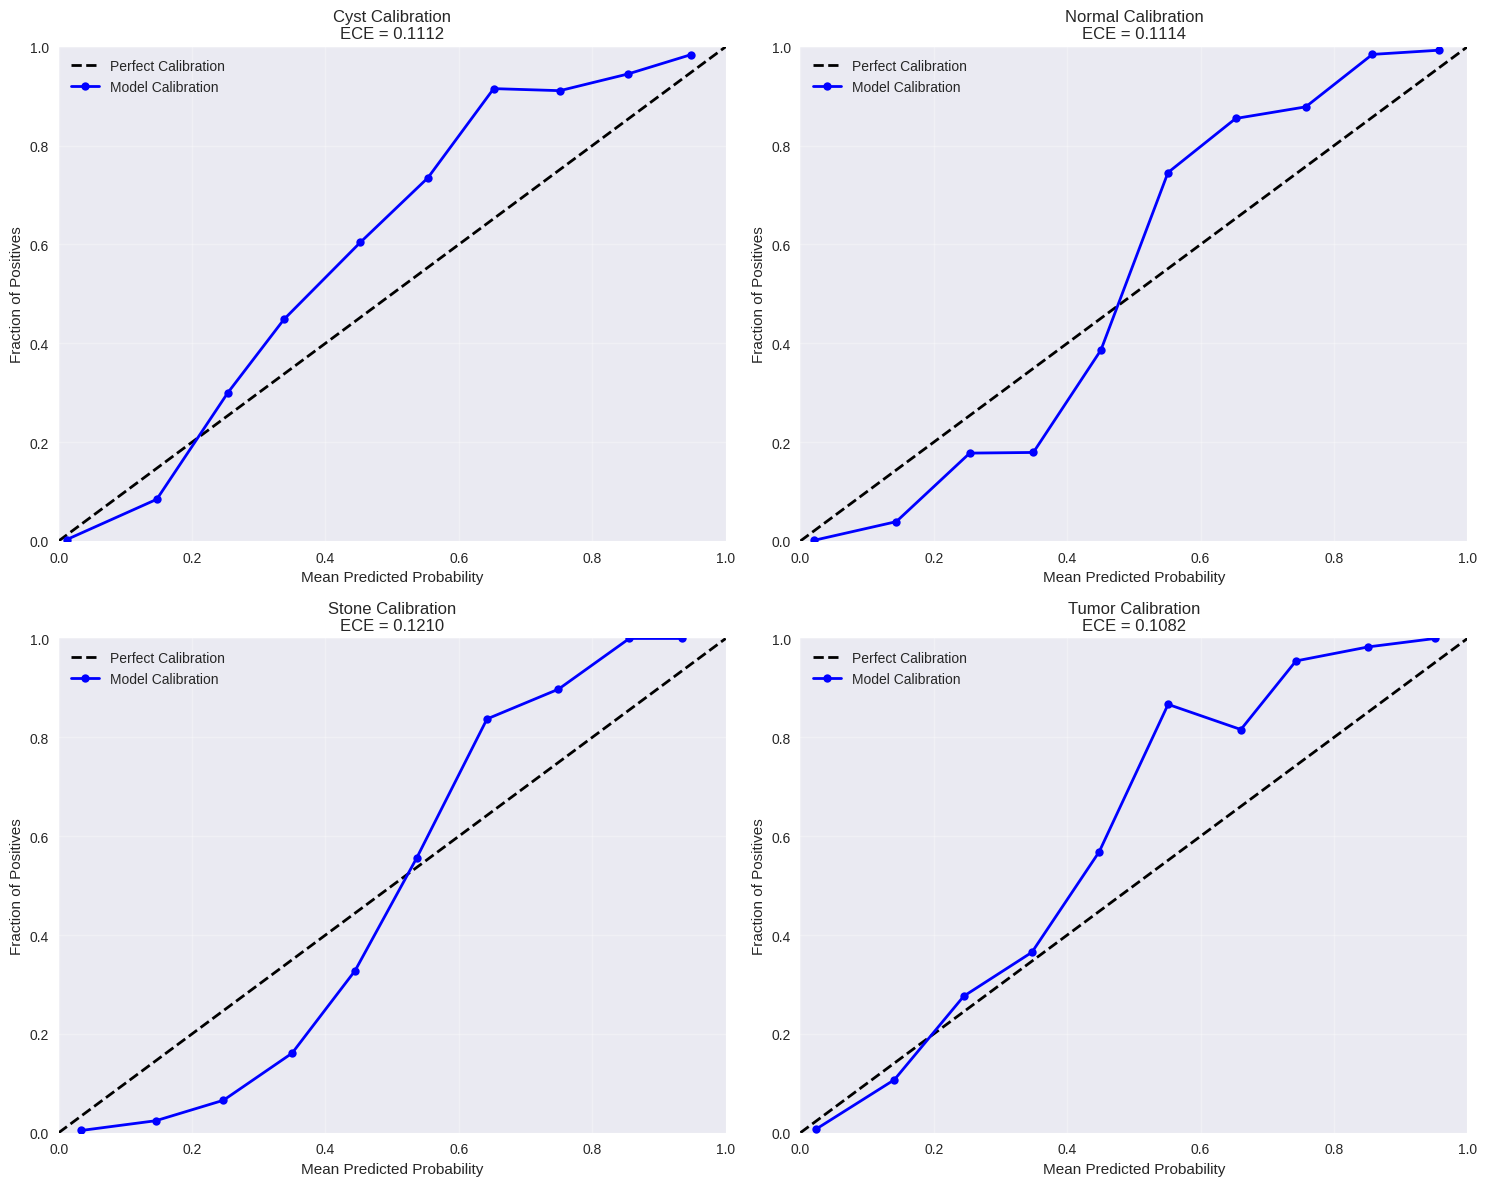

Calibration Summary (Expected Calibration Error):
  Cyst: 0.1112 Needs calibration
  Normal: 0.1114 Needs calibration
  Stone: 0.1210 Needs calibration
  Tumor: 0.1082 Needs calibration
  Average ECE: 0.1130
  Consider post-hoc calibration methods


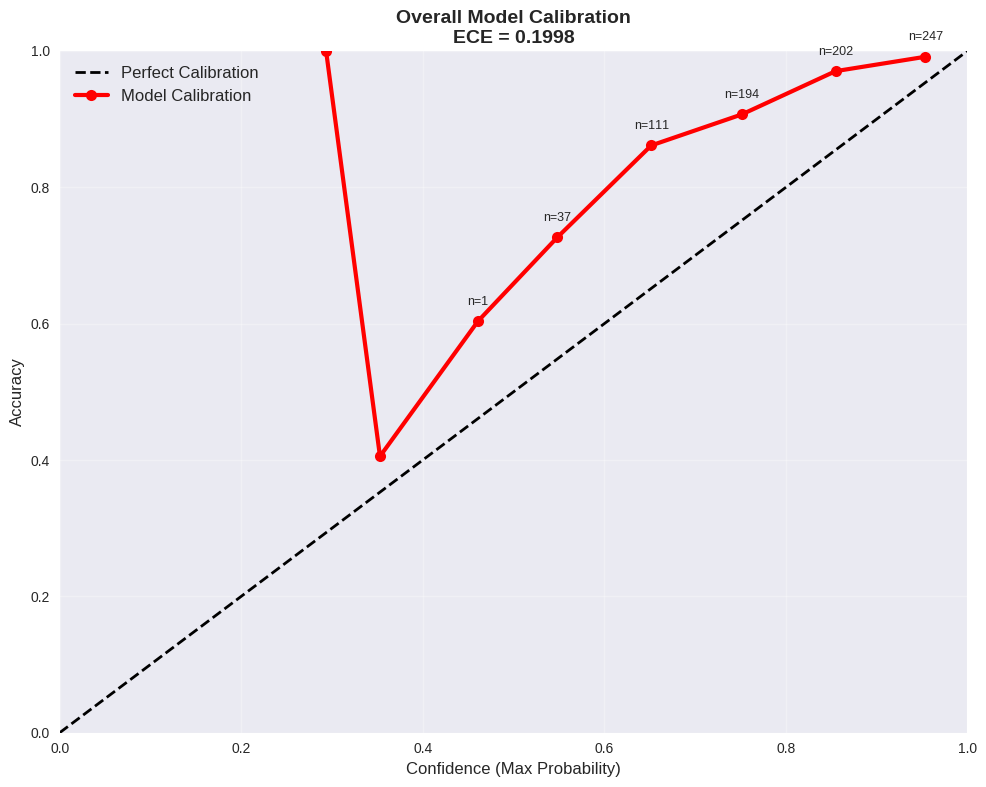


🎯 Overall Model Calibration:
  Expected Calibration Error: 0.1998
  Poor calibration - consider temperature scaling or Platt scaling


In [66]:
# Calibration Analysis
if test_results is not None:
    print("=" * 60)
    print("CALIBRATION ANALYSIS")
    print("=" * 60)
    
    # Calculate calibration for each class
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    calibration_scores = []
    
    for i, class_name in enumerate(CLASS_NAMES):
        # Get class probabilities and true labels
        class_probs = test_results['probabilities'][:, i]
        class_true = (test_results['targets'] == i).astype(int)
        
        # Calculate calibration curve
        try:
            fraction_pos, mean_pred_value = calibration_curve(
                class_true, class_probs, n_bins=10, strategy='uniform'
            )
            
            # Plot calibration curve
            ax = axes[i]
            ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
            ax.plot(mean_pred_value, fraction_pos, 'bo-', linewidth=2, 
                   markersize=6, label='Model Calibration')
            
            # Calculate Expected Calibration Error (ECE)
            ece = np.mean(np.abs(fraction_pos - mean_pred_value))
            calibration_scores.append(ece)
            
            ax.set_xlabel('Mean Predicted Probability')
            ax.set_ylabel('Fraction of Positives')
            ax.set_title(f'{class_name} Calibration\nECE = {ece:.4f}')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            
        except Exception as e:
            print(f"Warning: Could not compute calibration for {class_name}: {e}")
            calibration_scores.append(np.nan)
    
    plt.tight_layout()
    plt.show()
    
    # Calibration summary
    print(f"Calibration Summary (Expected Calibration Error):")
    valid_scores = [score for score in calibration_scores if not np.isnan(score)]
    
    if valid_scores:
        for class_name, ece in zip(CLASS_NAMES, calibration_scores):
            if not np.isnan(ece):
                status = "Well calibrated" if ece < 0.1 else "Needs calibration"
                print(f"  {class_name}: {ece:.4f} {status}")
        
        avg_ece = np.mean(valid_scores)
        print(f"  Average ECE: {avg_ece:.4f}")
        
        if avg_ece < 0.05:
            print(f"  Excellent overall calibration")
        elif avg_ece < 0.1:
            print(f"  Good overall calibration")
        else:
            print(f"  Consider post-hoc calibration methods")
    
    # Reliability diagram
    plt.figure(figsize=(10, 8))
    
    # Overall model calibration (using max probability)
    max_probs = np.max(test_results['probabilities'], axis=1)
    predicted_labels = np.argmax(test_results['probabilities'], axis=1)
    true_labels = test_results['targets']
    
    # Accuracy of predictions
    correct_predictions = (predicted_labels == true_labels).astype(int)
    
    try:
        fraction_pos, mean_pred_value = calibration_curve(
            correct_predictions, max_probs, n_bins=10, strategy='uniform'
        )
        
        plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
        plt.plot(mean_pred_value, fraction_pos, 'ro-', linewidth=3, 
                markersize=8, label='Model Calibration')
        
        # Add bin sizes
        bin_indices = np.digitize(max_probs, np.linspace(0, 1, 11)) - 1
        bin_counts = np.bincount(bin_indices, minlength=10)
        
        for i, (x, y, count) in enumerate(zip(mean_pred_value, fraction_pos, bin_counts)):
            if count > 0:
                plt.text(x, y + 0.02, f'n={count}', ha='center', va='bottom', fontsize=9)
        
        ece_overall = np.mean(np.abs(fraction_pos - mean_pred_value))
        
        plt.xlabel('Confidence (Max Probability)', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title(f'Overall Model Calibration\nECE = {ece_overall:.4f}', 
                 fontsize=14, fontweight='bold')
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()
        
        print(f"\n🎯 Overall Model Calibration:")
        print(f"  Expected Calibration Error: {ece_overall:.4f}")
        
        if ece_overall < 0.05:
            print(f"  Excellent calibration - predictions are reliable")
        elif ece_overall < 0.1:
            print(f"  Good calibration - predictions are mostly reliable")
        else:
            print(f"  Poor calibration - consider temperature scaling or Platt scaling")
            
    except Exception as e:
        print(f"Warning: Could not compute overall calibration: {e}")

ERROR ANALYSIS & MISCLASSIFICATION PATTERNS
Error Analysis Summary:
  Total samples: 1867
  Correctly classified: 1671
  Misclassified: 196
  Error rate: 0.1050

🔍 Misclassification Patterns:
True Class Predicted Class  Count Avg Uncertainty Avg Confidence
     Tumor          Normal     32          0.0316         0.7602
    Normal           Stone     27          0.0469         0.6868
     Stone            Cyst     25          0.0180         0.8203
    Normal           Tumor     25          0.0177         0.7803
      Cyst           Tumor     22          0.0360         0.7328
     Tumor            Cyst     19          0.0281         0.7923
      Cyst           Stone     18          0.0438         0.7111
     Stone          Normal     16          0.0294         0.7540
     Tumor           Stone      7          0.0622         0.6552
      Cyst          Normal      4          0.0499         0.6830
     Stone           Tumor      1          0.0455         0.6751

High-Confidence Errors:
  C

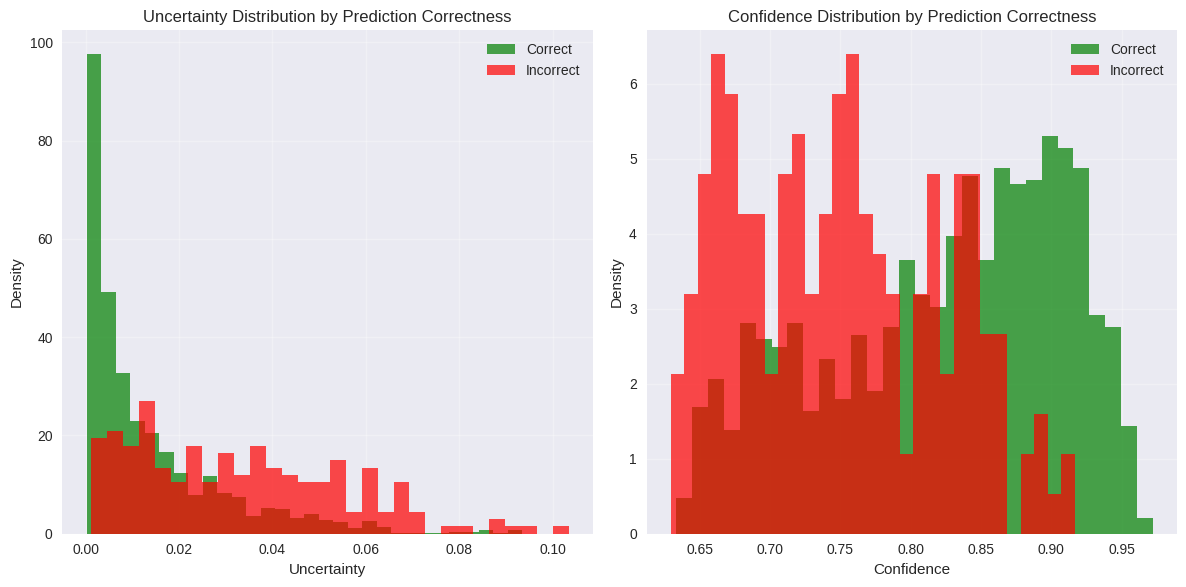

In [67]:
# Error Analysis and Misclassification Patterns
if test_results is not None:
    print("=" * 60)
    print("ERROR ANALYSIS & MISCLASSIFICATION PATTERNS")
    print("=" * 60)
    
    # Find misclassified samples
    misclassified_mask = test_results['predictions'] != test_results['targets']
    misclassified_indices = np.where(misclassified_mask)[0]
    
    print(f"Error Analysis Summary:")
    print(f"  Total samples: {len(test_results['targets'])}")
    print(f"  Correctly classified: {np.sum(~misclassified_mask)}")
    print(f"  Misclassified: {len(misclassified_indices)}")
    print(f"  Error rate: {len(misclassified_indices) / len(test_results['targets']):.4f}")
    
    # Analyze misclassification patterns
    print(f"\n🔍 Misclassification Patterns:")
    
    misclass_data = []
    for true_class in range(NUM_CLASSES):
        for pred_class in range(NUM_CLASSES):
            if true_class != pred_class:
                # Count this type of misclassification
                mask = (test_results['targets'] == true_class) & (test_results['predictions'] == pred_class)
                count = np.sum(mask)
                
                if count > 0:
                    # Calculate average uncertainty for this error type
                    avg_uncertainty = test_results['uncertainties'][mask].mean()
                    avg_confidence = test_results['confidence'][mask].mean()
                    
                    misclass_data.append({
                        'True Class': CLASS_NAMES[true_class],
                        'Predicted Class': CLASS_NAMES[pred_class],
                        'Count': count,
                        'Avg Uncertainty': f"{avg_uncertainty:.4f}",
                        'Avg Confidence': f"{avg_confidence:.4f}"
                    })
    
    if misclass_data:
        df_misclass = pd.DataFrame(misclass_data)
        df_misclass = df_misclass.sort_values('Count', ascending=False)
        print(df_misclass.to_string(index=False))
    
    # High-confidence errors (most concerning)
    high_conf_errors = misclassified_mask & (test_results['confidence'].flatten() > 0.8)
    high_conf_count = np.sum(high_conf_errors)
    
    print(f"\nHigh-Confidence Errors:")
    print(f"  Count: {high_conf_count}")
    print(f"  Percentage of errors: {high_conf_count / len(misclassified_indices) * 100:.1f}%")
    
    if high_conf_count > 0:
        print(f"  These are the most concerning errors (model is confident but wrong)")
        
        # Analyze high-confidence error patterns
        hce_indices = np.where(high_conf_errors)[0]
        print(f"\n  High-Confidence Error Breakdown:")
        
        for idx in hce_indices[:10]:  # Show first 10
            true_class = CLASS_NAMES[test_results['targets'][idx]]
            pred_class = CLASS_NAMES[test_results['predictions'][idx]]
            confidence = test_results['confidence'][idx]
            uncertainty = test_results['uncertainties'][idx]
            
            print(f"    Sample {idx}: {true_class} → {pred_class} "
                  f"(Conf: {confidence:.3f}, Unc: {uncertainty:.3f})")
    
    # Uncertainty vs Error Analysis
    print(f"\n🔬 Uncertainty vs Error Correlation:")
    
    # Calculate correlation between uncertainty and errors
    error_indicator = misclassified_mask.astype(int)
    corr_coef = np.corrcoef(test_results['uncertainties'], error_indicator)[0, 1]
    
    print(f"  Correlation coefficient: {corr_coef:.4f}")
    
    if corr_coef > 0.3:
        print(f"  Strong positive correlation - uncertainty indicates errors well")
    elif corr_coef > 0.1:
        print(f"  Moderate correlation - uncertainty somewhat indicates errors")
    else:
        print(f"  Weak correlation - uncertainty may not be reliable for error detection")
    
    # Plot uncertainty distribution for correct vs incorrect predictions
    plt.figure(figsize=(12, 6))
    
    # Subplot 1: Uncertainty distributions
    plt.subplot(1, 2, 1)
    correct_unc = test_results['uncertainties'][~misclassified_mask]
    incorrect_unc = test_results['uncertainties'][misclassified_mask]
    
    plt.hist(correct_unc, bins=30, alpha=0.7, color='green', label='Correct', density=True)
    plt.hist(incorrect_unc, bins=30, alpha=0.7, color='red', label='Incorrect', density=True)
    plt.xlabel('Uncertainty')
    plt.ylabel('Density')
    plt.title('Uncertainty Distribution by Prediction Correctness')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Confidence distributions
    plt.subplot(1, 2, 2)
    correct_conf = test_results['confidence'][~misclassified_mask]
    incorrect_conf = test_results['confidence'][misclassified_mask]
    
    plt.hist(correct_conf, bins=30, alpha=0.7, color='green', label='Correct', density=True)
    plt.hist(incorrect_conf, bins=30, alpha=0.7, color='red', label='Incorrect', density=True)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution by Prediction Correctness')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

CLINICAL DECISION SUPPORT ANALYSIS
Clinical Decision Support Thresholds:
  Low uncertainty threshold: 0.0028
  High uncertainty threshold: 0.0230

Performance by Uncertainty Level:
  Low Uncertainty:
    Samples: 467 (25.0%)
    Accuracy: 0.9893
  Medium Uncertainty:
    Samples: 933 (50.0%)
    Accuracy: 0.9218
  High Uncertainty:
    Samples: 467 (25.0%)
    Accuracy: 0.7473
    Excellent accuracy for low uncertainty cases

🎯 Clinical Decision Support Framework:
 Uncertainty Level  Sample Count Percentage Accuracy                          Recommendation
   Low Uncertainty           467      25.0%   0.9893           High confidence - Auto-report
Medium Uncertainty           933      50.0%   0.9218  Medium confidence - Review recommended
  High Uncertainty           467      25.0%   0.7473 Low confidence - Manual review required

Risk Stratification for Tumor Detection:
  Low Uncertainty:
    Tumor cases: 38
    Detected: 36
    Detection rate: 0.9474
  Medium Uncertainty:
    Tumor ca

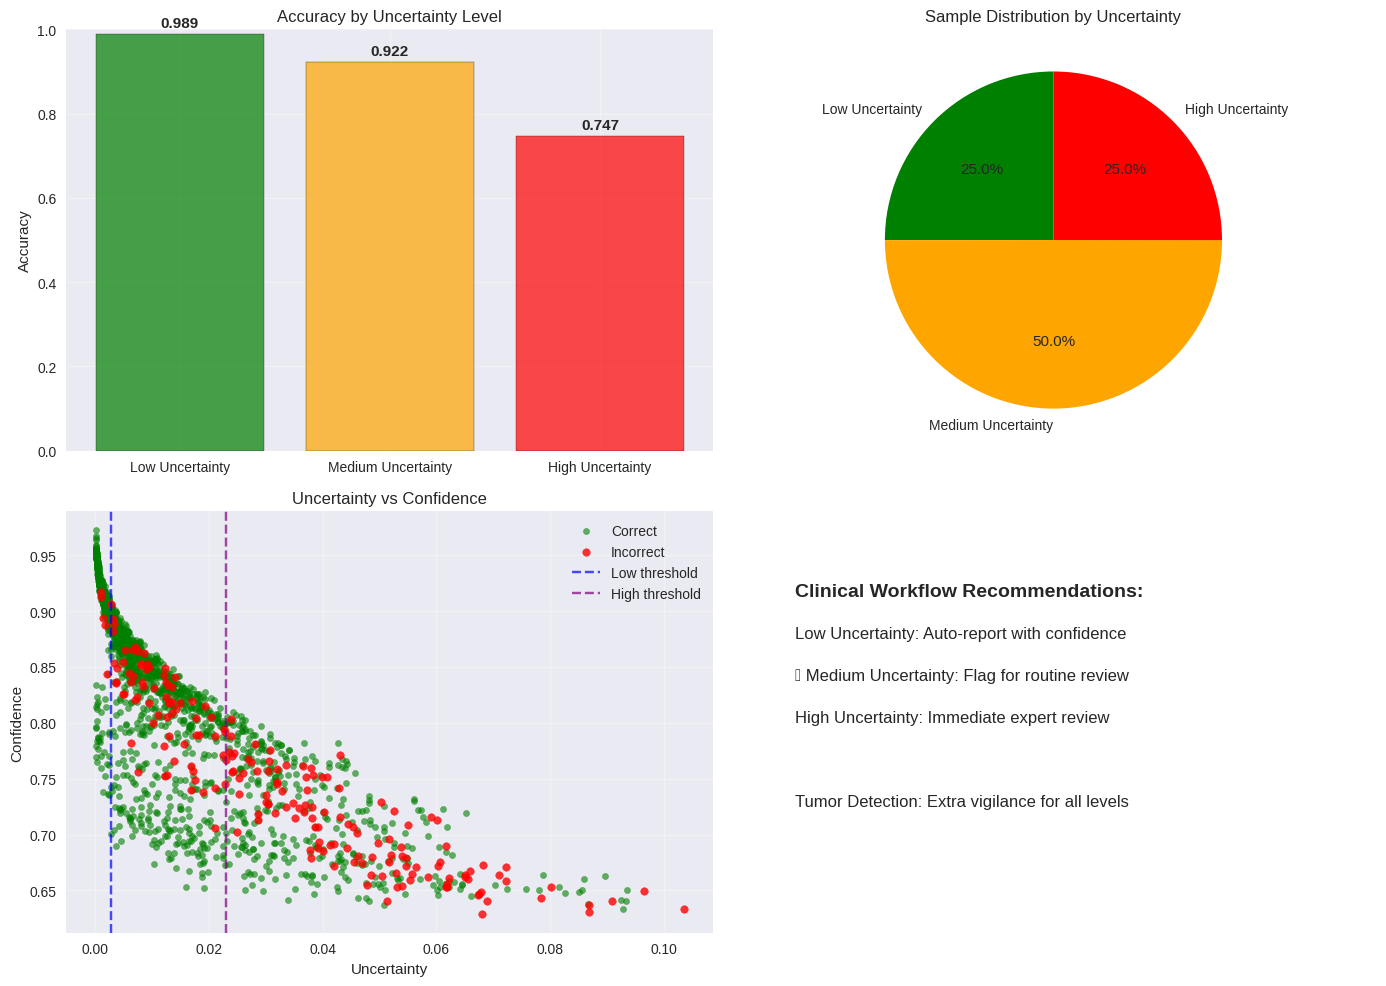

In [68]:
# Clinical Decision Support Analysis
if test_results is not None:
    print("=" * 60)
    print("CLINICAL DECISION SUPPORT ANALYSIS")
    print("=" * 60)
    
    # Define uncertainty thresholds for clinical decision-making
    low_uncertainty_threshold = np.percentile(test_results['uncertainties'], 25)
    high_uncertainty_threshold = np.percentile(test_results['uncertainties'], 75)
    
    print(f"Clinical Decision Support Thresholds:")
    print(f"  Low uncertainty threshold: {low_uncertainty_threshold:.4f}")
    print(f"  High uncertainty threshold: {high_uncertainty_threshold:.4f}")
    
    # Categorize predictions by uncertainty
    low_uncertainty_mask = test_results['uncertainties'] <= low_uncertainty_threshold
    medium_uncertainty_mask = (test_results['uncertainties'] > low_uncertainty_threshold) & \
                             (test_results['uncertainties'] <= high_uncertainty_threshold)
    high_uncertainty_mask = test_results['uncertainties'] > high_uncertainty_threshold
    
    # Analyze performance by uncertainty level
    uncertainty_categories = [
        ('Low Uncertainty', low_uncertainty_mask),
        ('Medium Uncertainty', medium_uncertainty_mask), 
        ('High Uncertainty', high_uncertainty_mask)
    ]
    
    print(f"\nPerformance by Uncertainty Level:")
    
    decision_support_data = []
    
    for category_name, mask in uncertainty_categories:
        if np.any(mask):
            cat_targets = test_results['targets'][mask]
            cat_predictions = test_results['predictions'][mask]
            cat_accuracy = np.mean(cat_targets == cat_predictions)
            cat_count = np.sum(mask)
            cat_percentage = cat_count / len(test_results['targets']) * 100
            
            decision_support_data.append({
                'Uncertainty Level': category_name,
                'Sample Count': cat_count,
                'Percentage': f"{cat_percentage:.1f}%",
                'Accuracy': f"{cat_accuracy:.4f}",
                'Recommendation': ''
            })
            
            print(f"  {category_name}:")
            print(f"    Samples: {cat_count} ({cat_percentage:.1f}%)")
            print(f"    Accuracy: {cat_accuracy:.4f}")
    
    # Add clinical recommendations
    if len(decision_support_data) >= 3:
        low_acc = float(decision_support_data[0]['Accuracy'])
        high_acc = float(decision_support_data[2]['Accuracy'])
        
        decision_support_data[0]['Recommendation'] = "High confidence - Auto-report"
        decision_support_data[1]['Recommendation'] = "Medium confidence - Review recommended"
        decision_support_data[2]['Recommendation'] = "Low confidence - Manual review required"
        
        if low_acc > 0.95:
            print(f"    Excellent accuracy for low uncertainty cases")
        else:
            print(f"    Consider adjusting uncertainty thresholds")
    
    df_decision_support = pd.DataFrame(decision_support_data)
    print(f"\n🎯 Clinical Decision Support Framework:")
    print(df_decision_support.to_string(index=False))
    
    # Risk stratification analysis
    print(f"\nRisk Stratification for Tumor Detection:")
    
    if 'Tumor' in CLASS_NAMES:
        tumor_class_idx = CLASS_NAMES.index('Tumor')
        tumor_true_mask = test_results['targets'] == tumor_class_idx
        tumor_pred_mask = test_results['predictions'] == tumor_class_idx
        
        # Tumor cases by uncertainty level
        for category_name, mask in uncertainty_categories:
            tumor_in_category = np.sum(tumor_true_mask & mask)
            tumor_detected = np.sum(tumor_true_mask & mask & tumor_pred_mask)
            
            if tumor_in_category > 0:
                detection_rate = tumor_detected / tumor_in_category
                print(f"  {category_name}:")
                print(f"    Tumor cases: {tumor_in_category}")
                print(f"    Detected: {tumor_detected}")
                print(f"    Detection rate: {detection_rate:.4f}")
                
                if category_name == "High Uncertainty" and detection_rate < 0.9:
                    print(f"    Critical: High uncertainty tumors may need immediate review")
                elif detection_rate > 0.95:
                    print(f"    Excellent tumor detection in this category")
    
    # Create uncertainty-based triage visualization
    plt.figure(figsize=(14, 10))
    
    # Subplot 1: Accuracy by uncertainty level
    plt.subplot(2, 2, 1)
    categories = [item['Uncertainty Level'] for item in decision_support_data]
    accuracies = [float(item['Accuracy']) for item in decision_support_data]
    colors = ['green', 'orange', 'red']
    
    bars = plt.bar(categories, accuracies, color=colors, alpha=0.7, edgecolor='black')
    plt.ylabel('Accuracy')
    plt.title('Accuracy by Uncertainty Level')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Subplot 2: Sample distribution
    plt.subplot(2, 2, 2)
    counts = [item['Sample Count'] for item in decision_support_data]
    plt.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Sample Distribution by Uncertainty')
    
    # Subplot 3: Uncertainty scatter plot
    plt.subplot(2, 2, 3)
    correct_mask = test_results['predictions'] == test_results['targets']
    
    plt.scatter(test_results['uncertainties'][correct_mask], 
               test_results['confidence'][correct_mask].flatten(),
               alpha=0.6, color='green', s=20, label='Correct')
    plt.scatter(test_results['uncertainties'][~correct_mask],
               test_results['confidence'][~correct_mask].flatten(), 
               alpha=0.8, color='red', s=30, label='Incorrect')
    
    plt.axvline(low_uncertainty_threshold, color='blue', linestyle='--', alpha=0.7, label='Low threshold')
    plt.axvline(high_uncertainty_threshold, color='purple', linestyle='--', alpha=0.7, label='High threshold')
    
    plt.xlabel('Uncertainty')
    plt.ylabel('Confidence')
    plt.title('Uncertainty vs Confidence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Clinical workflow
    plt.subplot(2, 2, 4)
    plt.text(0.1, 0.8, "Clinical Workflow Recommendations:", fontsize=14, fontweight='bold')
    plt.text(0.1, 0.7, "Low Uncertainty: Auto-report with confidence", fontsize=12)
    plt.text(0.1, 0.6, "🟡 Medium Uncertainty: Flag for routine review", fontsize=12)
    plt.text(0.1, 0.5, "High Uncertainty: Immediate expert review", fontsize=12)
    plt.text(0.1, 0.3, "Tumor Detection: Extra vigilance for all levels", fontsize=12)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

TRAINING VS TEST PERFORMANCE COMPARISON
Performance Comparison:
  Final Training Accuracy: 0.7436
  Final Validation Accuracy: 0.9052
  Test Accuracy: 0.8950
  Final Validation F1: 0.8756

🔍 Generalization Analysis:
  Train-Validation Gap: -0.1616
  Validation-Test Gap: 0.0102
  Good training-validation consistency
  Excellent validation-test consistency


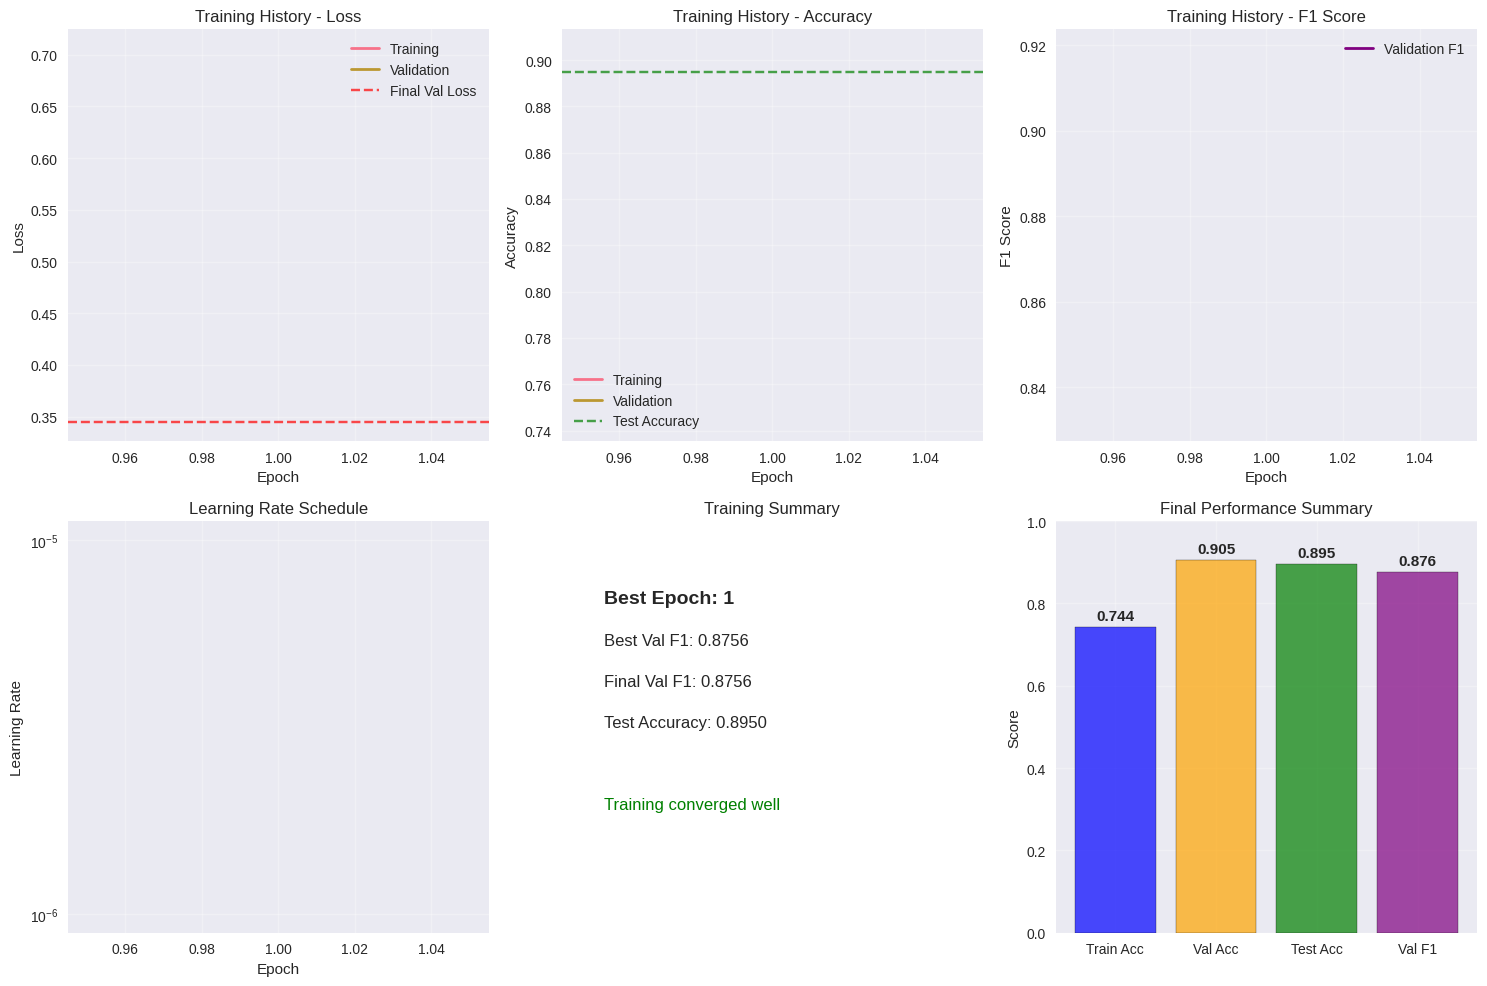

In [69]:
# Comparison with Training History
if training_history is not None and test_results is not None:
    print("=" * 60)
    print("TRAINING VS TEST PERFORMANCE COMPARISON")
    print("=" * 60)
    
    # Get final training metrics
    final_train_acc = training_history['train_acc'][-1]
    final_val_acc = training_history['val_acc'][-1]
    final_val_f1 = training_history['val_f1'][-1]
    
    # Calculate test metrics
    test_accuracy = np.mean(test_results['predictions'] == test_results['targets'])
    
    print(f"Performance Comparison:")
    print(f"  Final Training Accuracy: {final_train_acc:.4f}")
    print(f"  Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Final Validation F1: {final_val_f1:.4f}")
    
    # Overfitting analysis
    train_val_gap = final_train_acc - final_val_acc
    val_test_gap = final_val_acc - test_accuracy
    
    print(f"\n🔍 Generalization Analysis:")
    print(f"  Train-Validation Gap: {train_val_gap:.4f}")
    print(f"  Validation-Test Gap: {val_test_gap:.4f}")
    
    if train_val_gap > 0.05:
        print(f"  Some overfitting detected (train > val)")
    else:
        print(f"  Good training-validation consistency")
    
    if abs(val_test_gap) < 0.02:
        print(f"  Excellent validation-test consistency")
    elif abs(val_test_gap) < 0.05:
        print(f"  Good validation-test consistency")
    else:
        print(f"  Validation may not be representative of test performance")
    
    # Training curve analysis
    plt.figure(figsize=(15, 10))
    
    epochs = range(1, len(training_history['train_loss']) + 1)
    
    # Loss curves
    plt.subplot(2, 3, 1)
    plt.plot(epochs, training_history['train_loss'], label='Training', linewidth=2)
    plt.plot(epochs, training_history['val_loss'], label='Validation', linewidth=2)
    plt.axhline(y=training_history['val_loss'][-1], color='red', linestyle='--', alpha=0.7, label='Final Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History - Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy curves
    plt.subplot(2, 3, 2)
    plt.plot(epochs, training_history['train_acc'], label='Training', linewidth=2)
    plt.plot(epochs, training_history['val_acc'], label='Validation', linewidth=2)
    plt.axhline(y=test_accuracy, color='green', linestyle='--', alpha=0.7, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training History - Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # F1 score
    plt.subplot(2, 3, 3)
    plt.plot(epochs, training_history['val_f1'], label='Validation F1', linewidth=2, color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training History - F1 Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Learning rate
    plt.subplot(2, 3, 4)
    plt.plot(epochs, training_history['learning_rate'], linewidth=2, color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    # Best epoch analysis
    plt.subplot(2, 3, 5)
    best_epoch = np.argmax(training_history['val_f1']) + 1
    best_f1 = max(training_history['val_f1'])
    
    plt.text(0.1, 0.8, f"Best Epoch: {best_epoch}", fontsize=14, fontweight='bold')
    plt.text(0.1, 0.7, f"Best Val F1: {best_f1:.4f}", fontsize=12)
    plt.text(0.1, 0.6, f"Final Val F1: {final_val_f1:.4f}", fontsize=12)
    plt.text(0.1, 0.5, f"Test Accuracy: {test_accuracy:.4f}", fontsize=12)
    
    if best_epoch < len(epochs) - 5:
        plt.text(0.1, 0.3, "Early stopping may have helped", fontsize=12, color='orange')
    else:
        plt.text(0.1, 0.3, "Training converged well", fontsize=12, color='green')
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('Training Summary')
    
    # Performance summary
    plt.subplot(2, 3, 6)
    metrics = ['Train Acc', 'Val Acc', 'Test Acc', 'Val F1']
    values = [final_train_acc, final_val_acc, test_accuracy, final_val_f1]
    colors = ['blue', 'orange', 'green', 'purple']
    
    bars = plt.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
    plt.ylabel('Score')
    plt.title('Final Performance Summary')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()